In [55]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import multiprocessing
import os
import pickle 
import seaborn as sns
import string
import theano
import time

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import combinations

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

synth_streamflow_path  = 'data/synthetic_streamflow.pkl'

with open(synth_streamflow_path, 'rb') as src:
    synthetic_streamflow = pickle.load(src)
    
input_filepath         = 'data/strawberry_river_arkansas_07074000.csv'
static_params_filepath = 'data/gr4j_static_params.pkl'
synth_streamflow_path  = 'data/synthetic_streamflow.pkl'

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

T     = 300
start = 15115

data = pd.read_csv(input_filepath).iloc[start:start+T]
times = pd.DatetimeIndex(data['year'].astype(str) + '-' + data['month'].astype(str)+ '-' + data['day'].astype(str))

### Plot of original dataset 

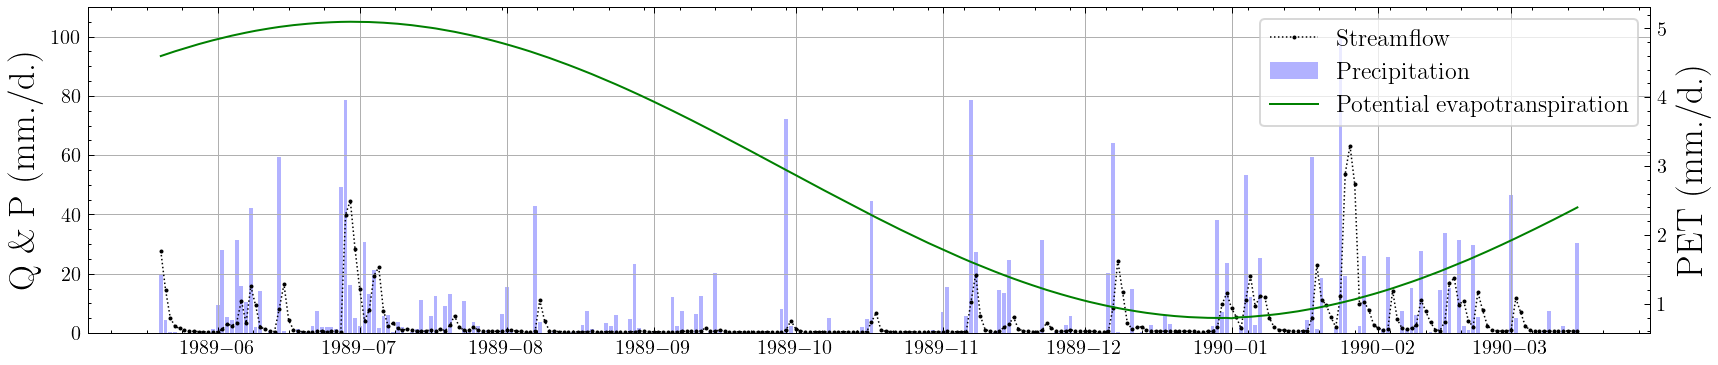

In [87]:
plt.figure(figsize=(14,3))

handles = []

handles += plt.plot(times,data['q'].values, color='k',linewidth=0.75, marker='o',
              markersize=1, label='Streamflow', linestyle=':')
handles.append(plt.bar(times,height=data['p'].values, color='b',alpha=0.3, label='Precipitation'))
plt.ylabel('Q \& P (mm./d.)', fontsize=18)
plt.grid('on')
plt.ylim(0,110)
twinx = plt.gca().twinx()
handles += twinx.plot(times,data['pet'].values, color='g', label='Potential evapotranspiration')
twinx.set_ylabel('PET (mm./d.)', fontsize=18)

labs = [l.get_label() for l in handles]
twinx.legend(handles, labs, loc='upper right', frameon=True, framealpha=0.75, fontsize=12)
plt.xlabel('Date');
plt.savefig('./figures/original_streamflow.png', dpi=300, bbox_inches='tight')

### Plots of streamflow and base model fit

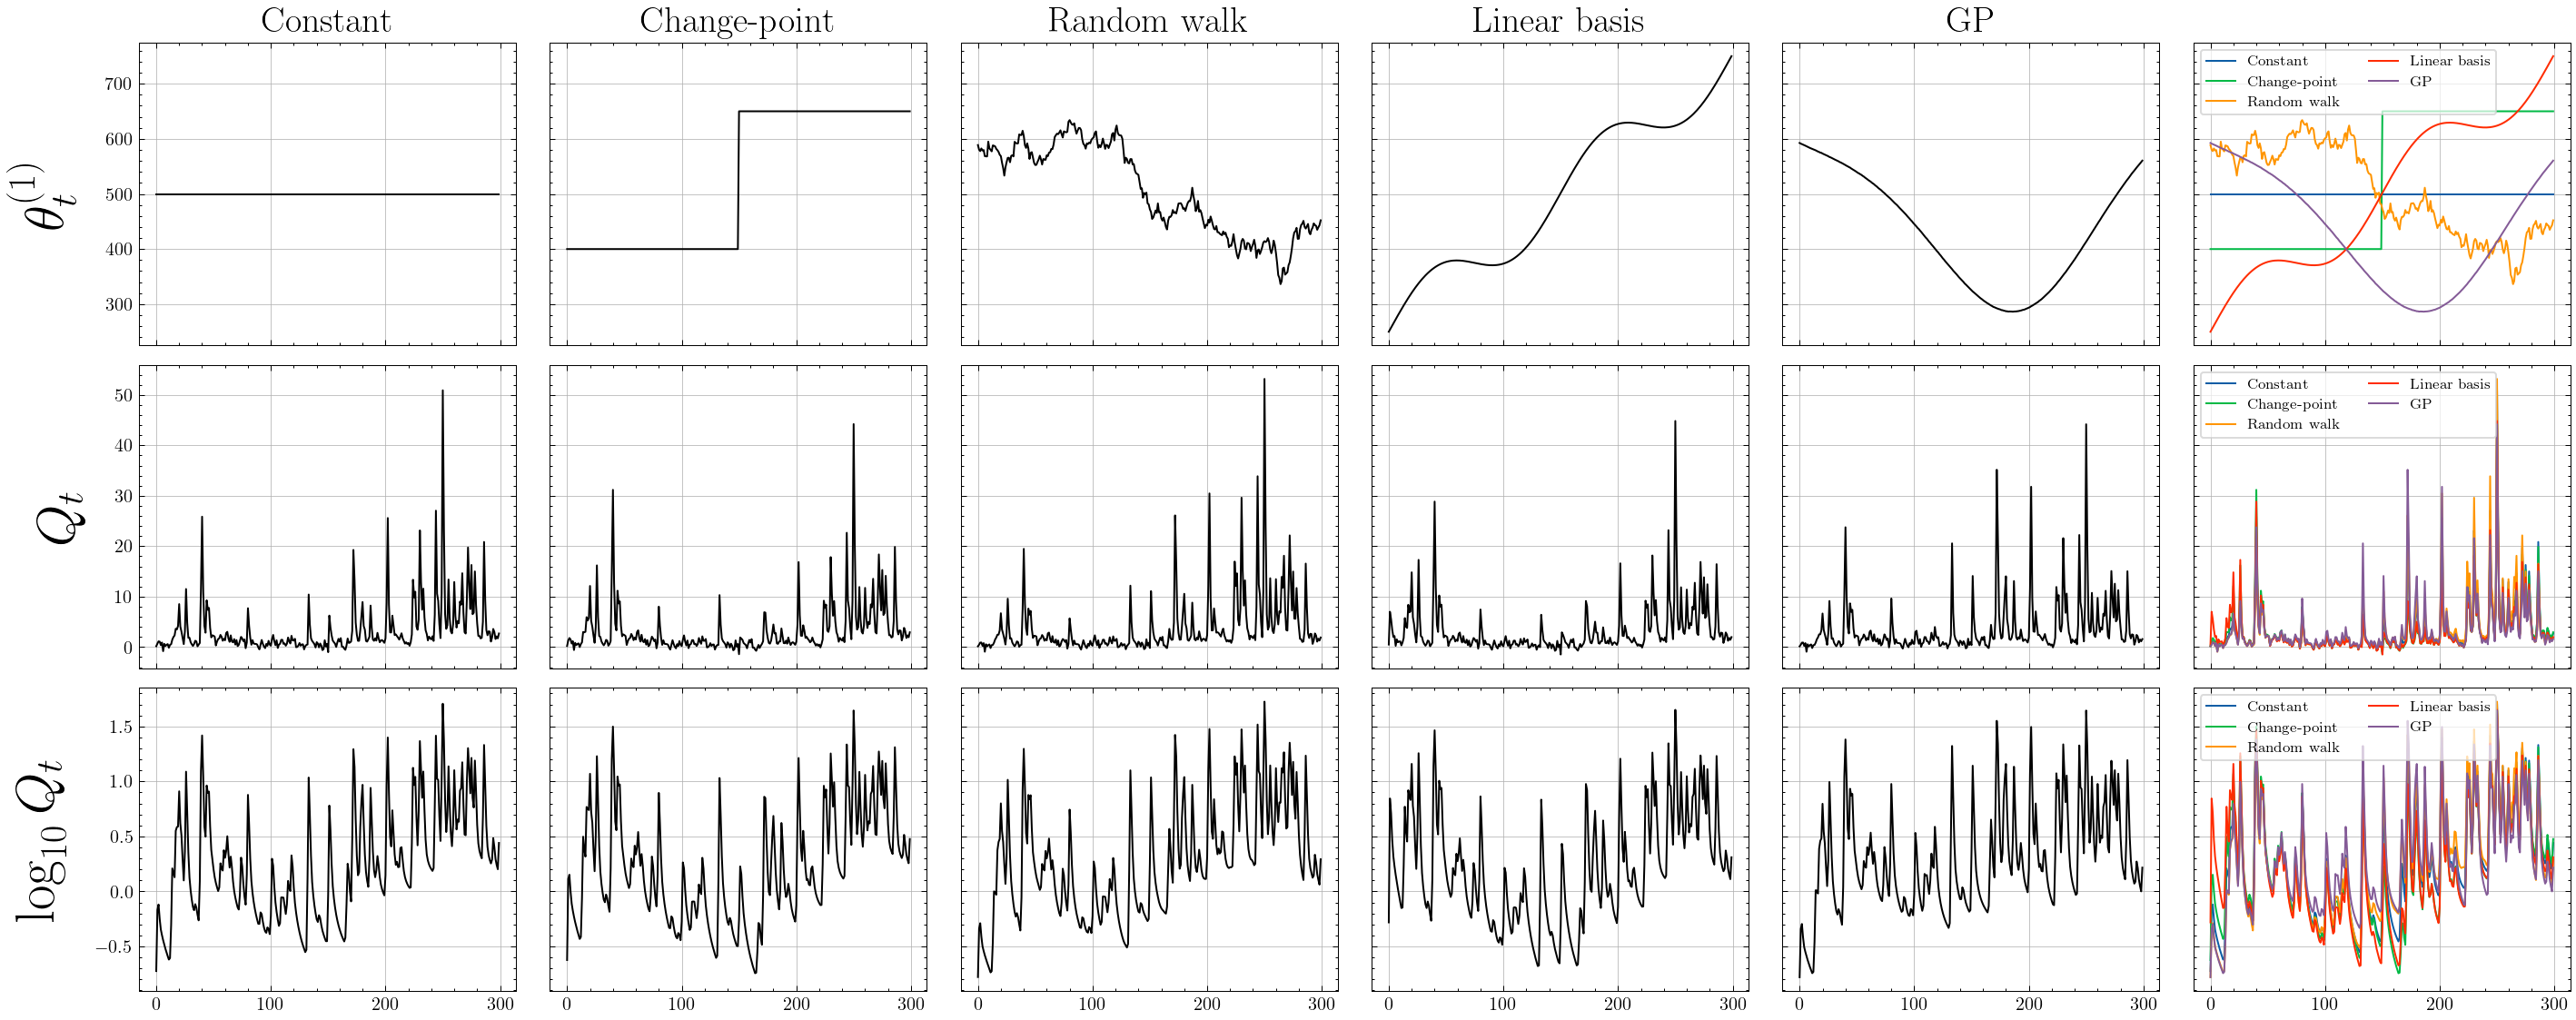

In [130]:
fig, axes = plt.subplots(3,6, figsize=(20,8), sharex=True, sharey='row')
ctr       = 0

plt.minorticks_on()

label_arrays = [()]*3

ylabels = ['$\\theta_t^{(1)}$', '$Q_t$', '$\log_{10} Q_t$']

for name, samples in synthetic_streamflow.items():

    axes[0,ctr].plot(samples['theta_1'].T.squeeze(), color='k')
    axes[1,ctr].plot(samples['streamflow'].T.squeeze(), color='k')
    axes[2,ctr].plot(np.log10(samples['raw_streamflow'].T.squeeze()), color='k')

    axes[0,ctr].set_title(name, fontsize=20)
    label_arrays[0] += tuple(axes[0,-1].plot(samples['theta_1'].T.squeeze(), label=name))
    label_arrays[1] += tuple(axes[1,-1].plot(samples['streamflow'].T.squeeze(), label=name))
    label_arrays[2] += tuple(axes[2,-1].plot(np.log10(samples['raw_streamflow'].T.squeeze()), label=name))
    ctr += 1
    
[ax.grid(True, alpha=0.75) for ax in axes.ravel()]
                    
for i in range(3):
    plt.sca(axes[i,-1])
    labs = [l.get_label() for l in label_arrays[i]]

    plt.legend(label_arrays[i], labs, fontsize=8, ncol=2, framealpha=0.7, frameon=True)
    axes[i,0].set_ylabel(ylabels[i], fontsize=30, labelpad=16)
                    
plt.tight_layout()
plt.savefig('./figures/synthetic_streamflow.png', dpi=300)

### Plots of posterior estimates of $\theta^{(1)}_t$

In [3]:
summaries = {}
traces    = {}


Processing Constant_Constant
Processing Constant_Change-point
Processing Constant_Random walk
Processing Constant_Linear basis
Processing Constant_GP
Processing Change-point_Constant
Processing Change-point_Change-point
Processing Change-point_Random walk
Processing Change-point_Linear basis
Processing Change-point_GP
Processing Random walk_Constant
Processing Random walk_Change-point
Processing Random walk_Random walk
Processing Random walk_Linear basis
Processing Random walk_GP
Processing Linear basis_Constant
Processing Linear basis_Change-point
Processing Linear basis_Random walk
Processing Linear basis_Linear basis
Processing Linear basis_GP
Processing GP_Constant
Processing GP_Change-point
Processing GP_Random walk
Processing GP_Linear basis
Processing GP_GP


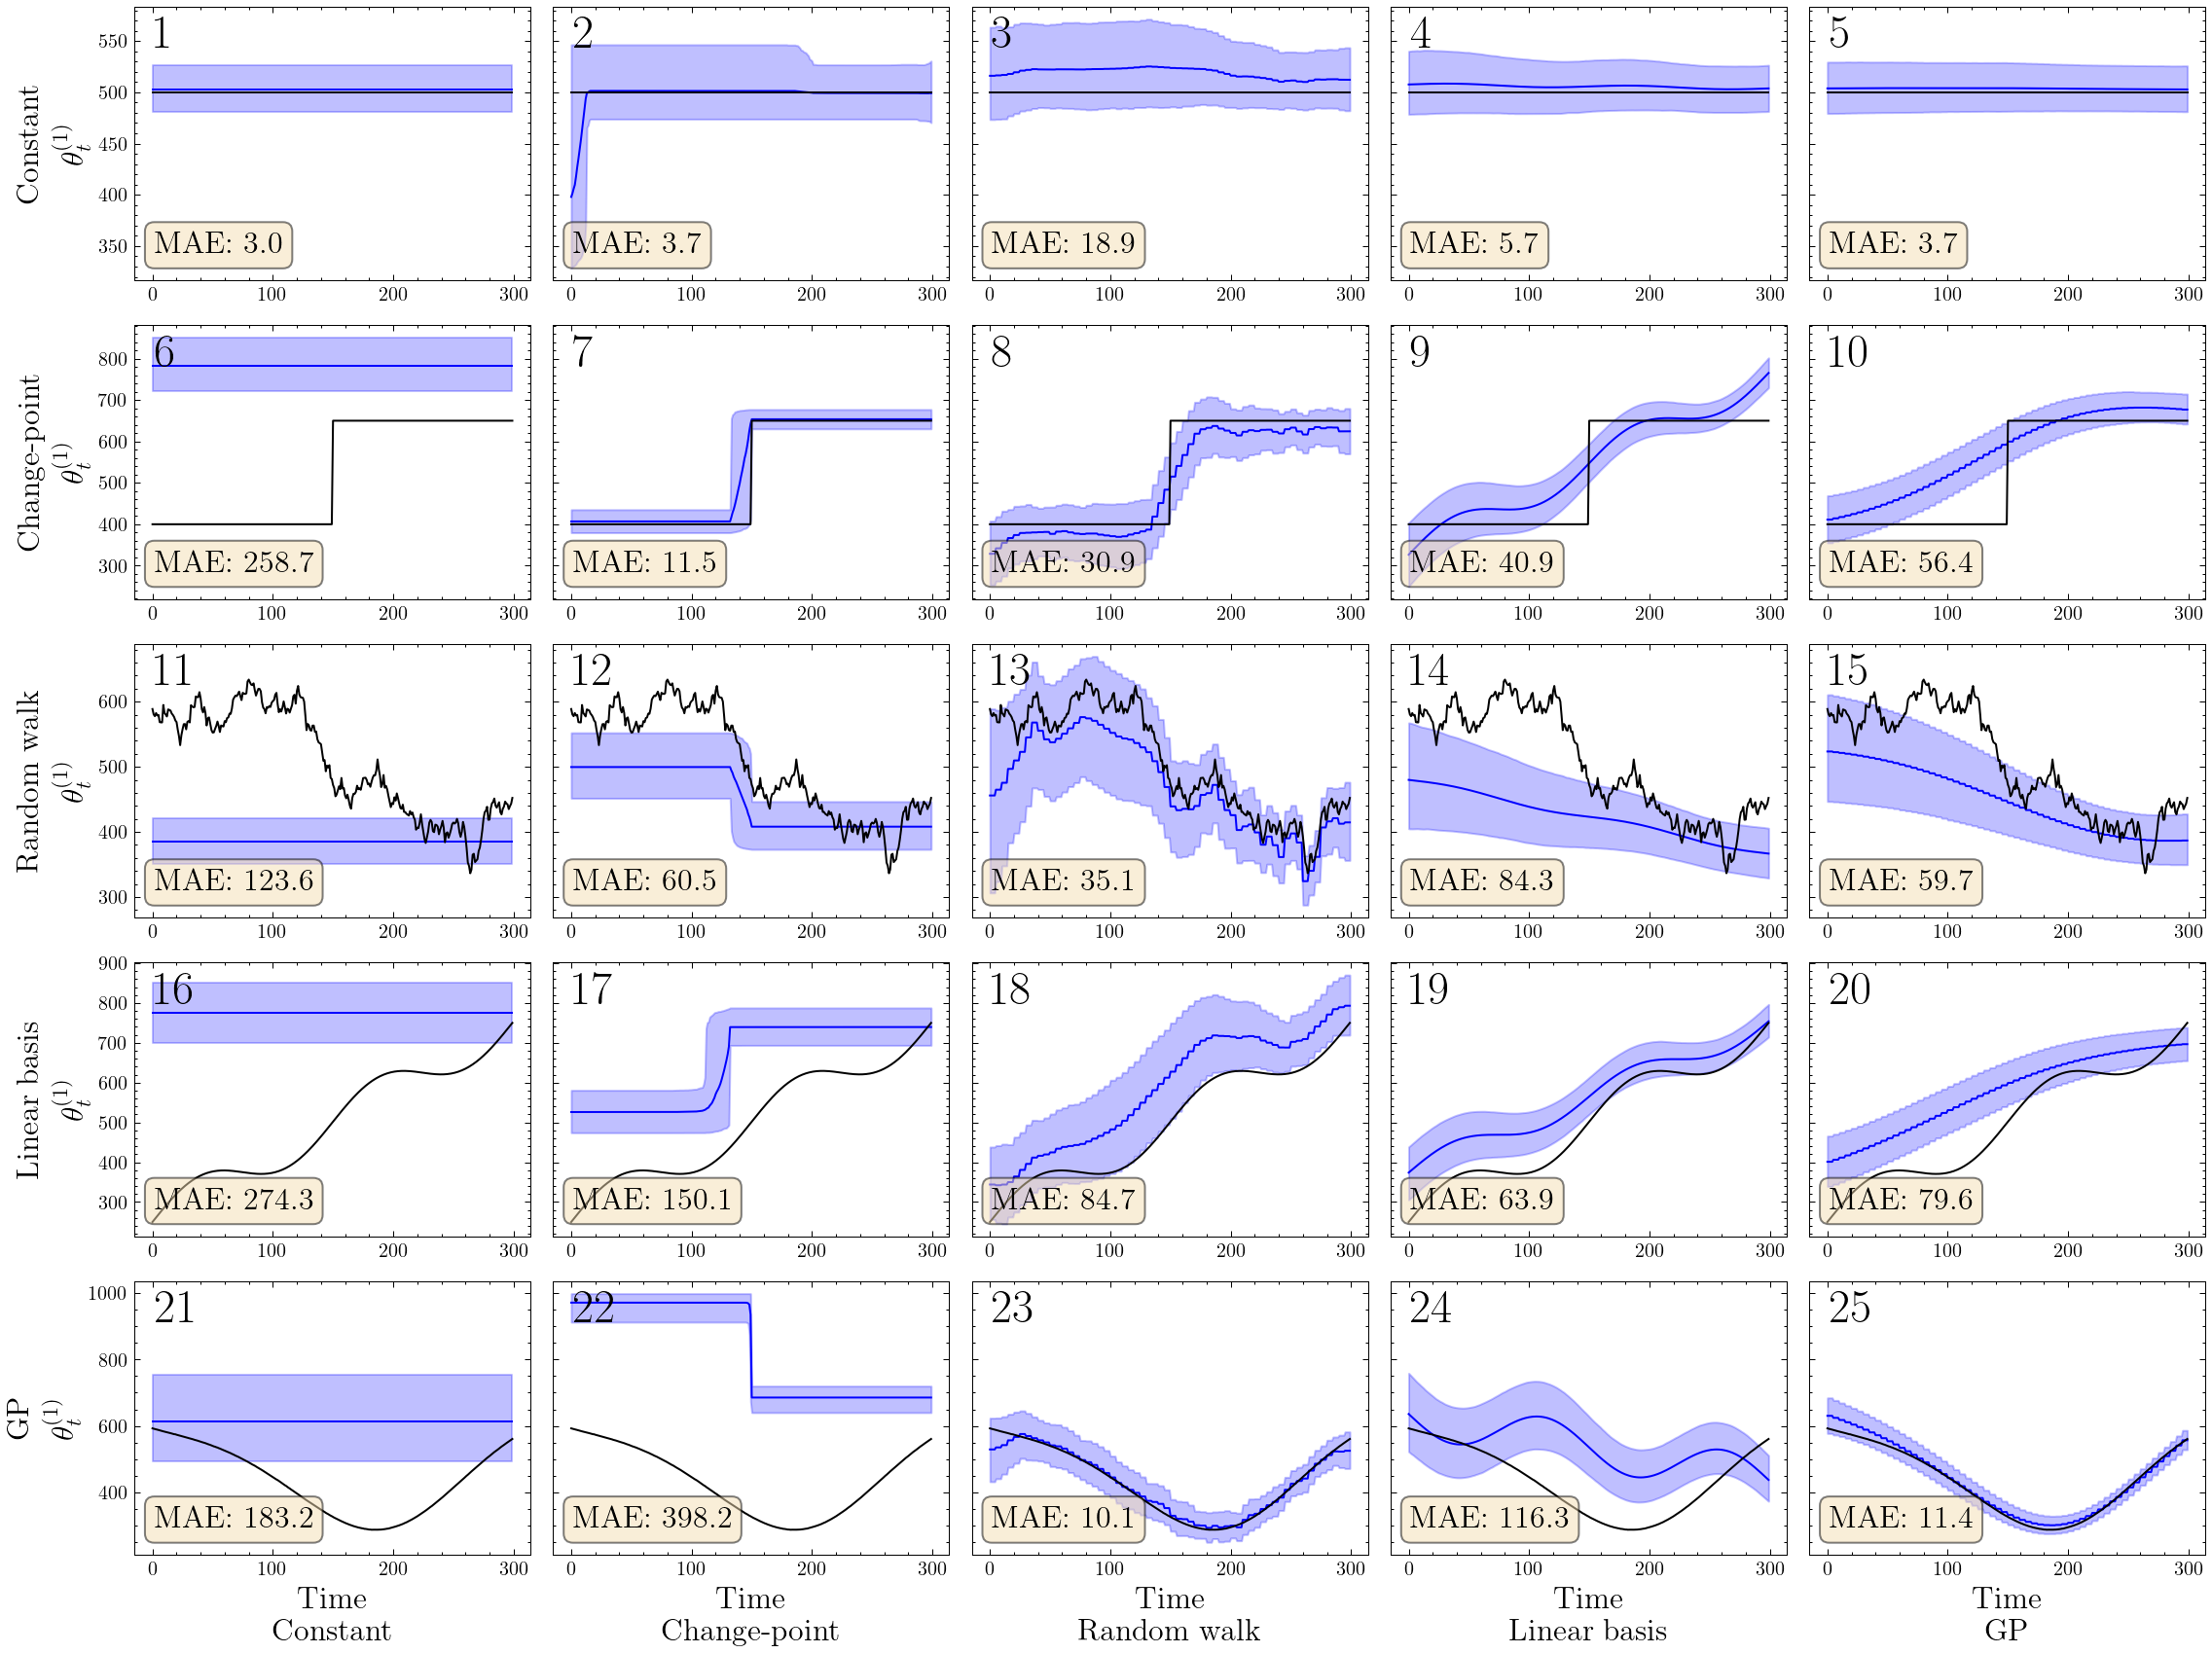

In [26]:
load_dir = './traces/run_8_30/'

generate_summary = False
add_inset        = False
names            =  ['Constant', 'Change-point', 'Random walk', 'Linear basis', 'GP']

M = len(names)

fig, axes = plt.subplots(M,M, figsize=(16,12), sharey='row')
axes_2d   = axes
axes      = axes.ravel()
plot_idx  = 0
traces    = {}

bbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


for n1 in names:
    for n2 in names:
        token = f'{n1}_{n2}'
        print(f'Processing {token}')

        filename = token + '.pkl'
        filepath = load_dir + filename
        if filename in os.listdir(load_dir):
            tuple_key = (n1,n2)
            
            if tuple_key not in traces.keys():
                trace = pickle.load(open(filepath, 'rb'))
                traces[tuple_key] = trace
            else:
                trace = traces[tuple_key]

            if tuple_key not in summaries.keys() and generate_summary:
                summaries[tuple_key] = az.summary(trace)  
                
            samples        = trace['theta_1']
            bounds         = np.percentile(samples, q=[2.5, 97.5], axis=0)
            posterior_mean = samples.mean(axis=0)
            true           = synthetic_streamflow[n1]['theta_1'].squeeze()
            
            MAE = np.mean(np.abs(posterior_mean-true))            
            plt.sca(axes[plot_idx])
            plt.text(0.05, 0.85, 
                     str(plot_idx+1), fontsize=24, 
                     transform=axes[plot_idx].transAxes,
                     fontweight='bold')
            
            plt.text(0.05, 0.1, 
                     f'MAE: {MAE:.1f}', fontsize=16, 
                     transform=axes[plot_idx].transAxes,
                     fontweight='bold', bbox=bbox_props)
            
            plt.plot(posterior_mean, color='b')
            plt.fill_between(np.arange(samples.shape[-1]), bounds[0], bounds[1], color='b', alpha=0.25) 
            plt.plot(true, color='k')
            
        if add_inset:
            inset_ax = inset_axes(axes[plot_idx], width=0.7, height=0.7, loc='lower right')
            inset_ax.scatter(true, posterior_mean, color='k', s=3)
            
        plot_idx +=1 
        
for i, name in enumerate(names):
    axes_2d[-1, i].set_xlabel('Time'+'\n'+name, fontsize=16, fontweight='bold')
    axes_2d[i, 0].set_ylabel(name + '\n' + '$\\theta^{(1)}_t$', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/large_plot.png', dpi=300)

### Calculate R-hat values

In [5]:
def split_to_chains(array, nchains):
    nsamples = array.shape[0]
    bins = np.linspace(0,nsamples,nchains+1).astype(int)
    blocks = zip(bins[0:-1], bins[1:])
    chains = [array[start:end] for start, end in blocks]
    return np.stack(chains, axis=0)

In [6]:
vars_to_summarize = ['theta_1']

traces_as_chains = {}
summaries = {}
for name, trace in traces.items():
    traces_as_chains[name] = {}
    
    for var in vars_to_summarize:
        traces_as_chains[name][var] = split_to_chains(trace[var], 2)
        
    summaries[name] = az.summary(traces_as_chains[name])
    print(name, summaries[name]['r_hat'].max())
        

('Constant', 'Constant') 1.0
('Constant', 'Change-point') 1.64
('Constant', 'Random walk') 1.0
('Constant', 'Linear basis') 1.0
('Constant', 'GP') 1.0
('Change-point', 'Constant') 1.0
('Change-point', 'Change-point') 1.0
('Change-point', 'Random walk') 1.0
('Change-point', 'Linear basis') 1.0
('Change-point', 'GP') 1.0
('Random walk', 'Constant') 1.0
('Random walk', 'Change-point') 1.0
('Random walk', 'Random walk') 1.0
('Random walk', 'Linear basis') 1.0
('Random walk', 'GP') 1.0
('Linear basis', 'Constant') 1.0
('Linear basis', 'Change-point') 1.0
('Linear basis', 'Random walk') 1.0
('Linear basis', 'Linear basis') 1.0
('Linear basis', 'GP') 1.0
('GP', 'Constant') 1.0
('GP', 'Change-point') 1.0
('GP', 'Random walk') 1.0
('GP', 'Linear basis') 1.0
('GP', 'GP') 1.02


In [15]:
summaries[('Constant', 'Change-point')]

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
theta_1[0]    397.906  71.992  327.612  539.680     49.447   41.538       2.0   
theta_1[1]    401.218  72.796  328.679  539.680     48.389   40.215       2.0   
theta_1[2]    405.720  73.895  328.843  539.028     46.892   38.424       2.0   
theta_1[3]    409.645  74.505  329.400  538.641     45.404   36.825       3.0   
theta_1[4]    417.685  75.814  330.369  539.028     42.285   33.662       3.0   
...               ...     ...      ...      ...        ...      ...       ...   
theta_1[295]  498.922  14.049  473.714  526.771      4.083    3.012      12.0   
theta_1[296]  498.982  14.332  472.094  525.778      4.146    3.057      12.0   
theta_1[297]  498.986  14.399  472.073  525.949      4.149    3.060      12.0   
theta_1[298]  499.152  15.217  472.094  526.771      4.177    3.026      13.0   
theta_1[299]  499.015  15.771  471.863  527.797      3.984    2.893      16.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
theta_1[0]       2.0       3.0      14.0   1.64  
theta_1[1]       2.0       3.0      14.0   1.61  
theta_1[2]       2.0       3.0      14.0   1.57  
theta_1[3]       3.0       4.0      14.0   1.54  
theta_1[4]       3.0       4.0      14.0   1.49  
...              ...       ...       ...    ...  
theta_1[295]    11.0      12.0      23.0   1.11  
theta_1[296]    12.0      12.0      23.0   1.11  
theta_1[297]    12.0      13.0      22.0   1.11  
theta_1[298]    13.0      13.0      21.0   1.11  
theta_1[299]    15.0      15.0      24.0   1.10  

[300 rows x 11 columns]

### Plots of non-TVP parameters

#### Plotting settings and pre-processing to rename variables

In [29]:
kde_kwargs = {
    'shade':True, 'color':'cyan', 'bw_method':0.2, 'levels':4
}

latex_names = {
    'err_sd'      : '$\sigma_{\epsilon}$',
    'rho'         : '$\\rho$',
    'gp_scale'    : '$\sigma_{GP}$',
    'intercept'   : '$\\alpha$',
    'S0'          : '$S_0$' ,
    'R0'          : '$R_0$',
    'theta_static_0':'$\\theta^{(2)}$',
    'theta_static_1':'$\\theta^{(3)}$',
    'theta_static_2':'$\\theta^{(4)}$',
    'beta_sigma'  : '$\sigma_{\\beta}$',
    'sigma_delta' : '$\sigma_{\delta}$',
    'changepoint' : '$\\tau_c$'
}

trace_extra_vars = {}

for key, trace in traces.items():
    for i in range(0,3):
        trace_extra_vars[f'theta_static_{i}'] = trace['theta_static'][...,i]

#### Generating pairwise posterior distribution plots

In [43]:
overwrite = True

('Constant', 'Constant')
('Constant', 'Change-point')
('Constant', 'Random walk')
('Constant', 'Linear basis')
('Constant', 'GP')
('Change-point', 'Constant')
('Change-point', 'Change-point')
('Change-point', 'Random walk')
('Change-point', 'Linear basis')
('Change-point', 'GP')
('Random walk', 'Constant')
('Random walk', 'Change-point')
('Random walk', 'Random walk')
('Random walk', 'Linear basis')
('Random walk', 'GP')
('Linear basis', 'Constant')
('Linear basis', 'Change-point')
('Linear basis', 'Random walk')
('Linear basis', 'Linear basis')
('Linear basis', 'GP')
('GP', 'Constant')


/var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_6280/2350909786.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(P,P, figsize=(fig_size_inches,fig_size_inches),


('GP', 'Change-point')
('GP', 'Random walk')
('GP', 'Linear basis')
('GP', 'GP')


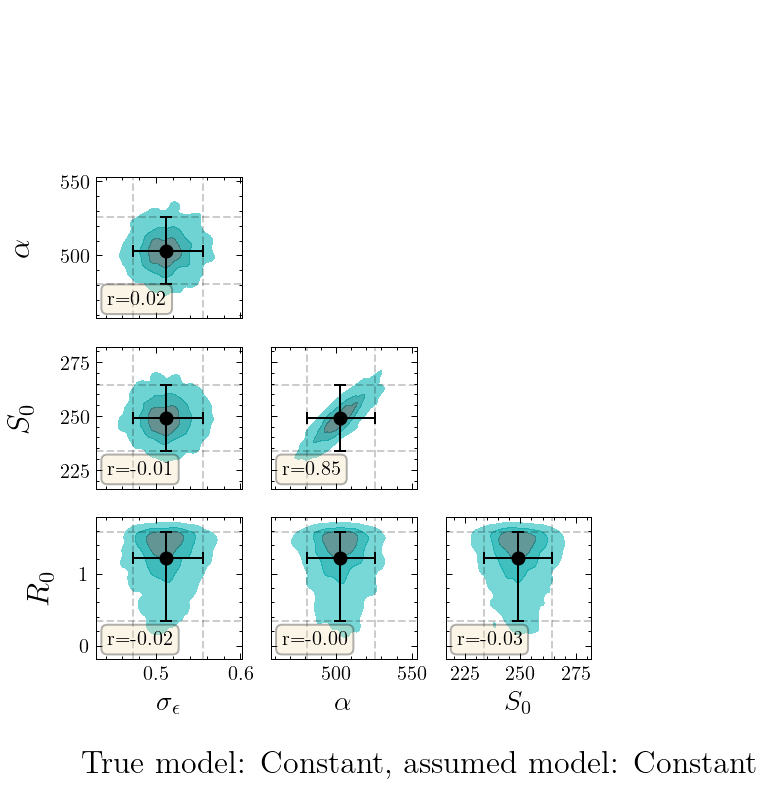

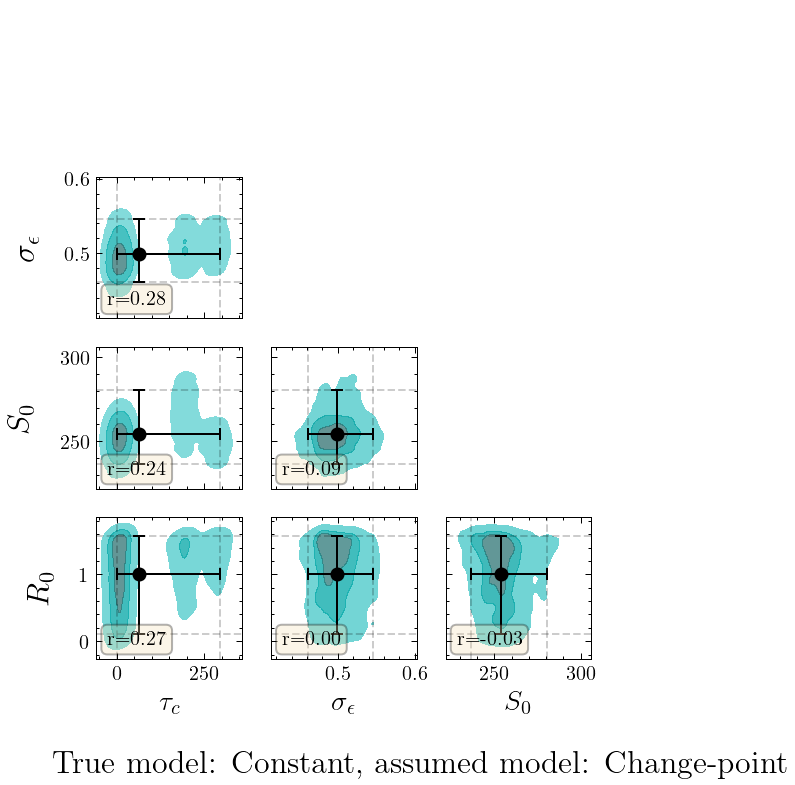

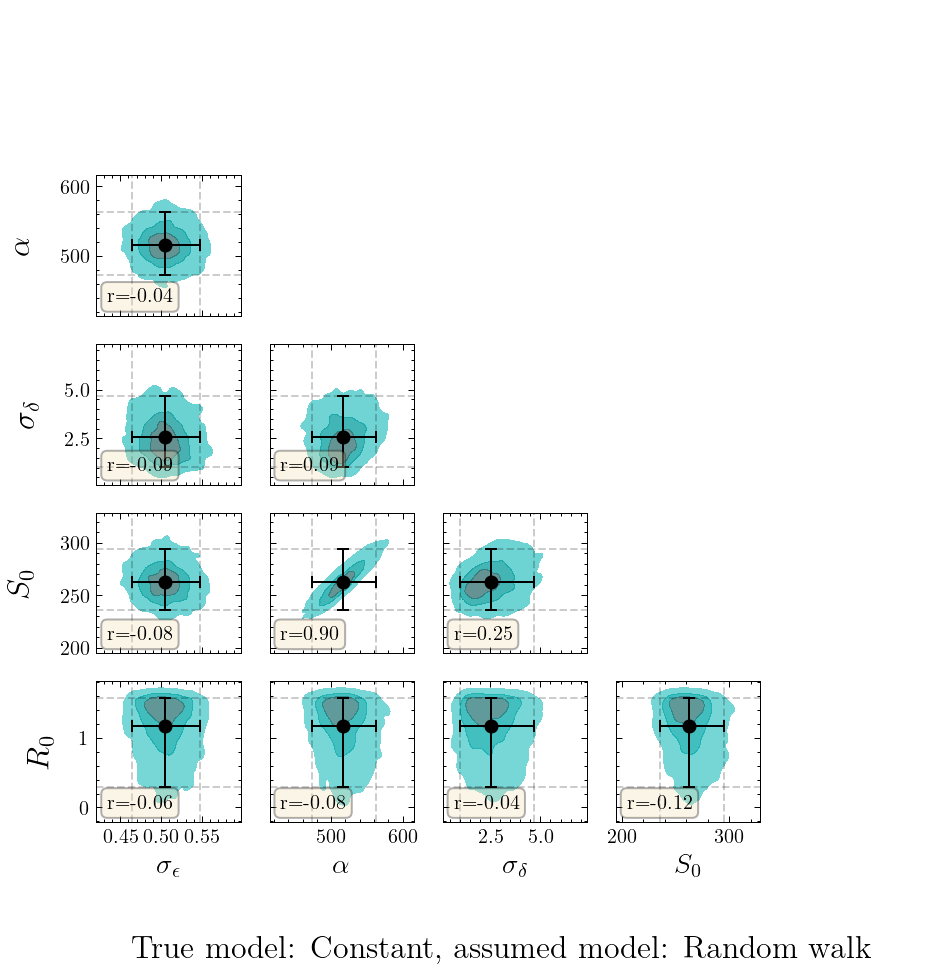

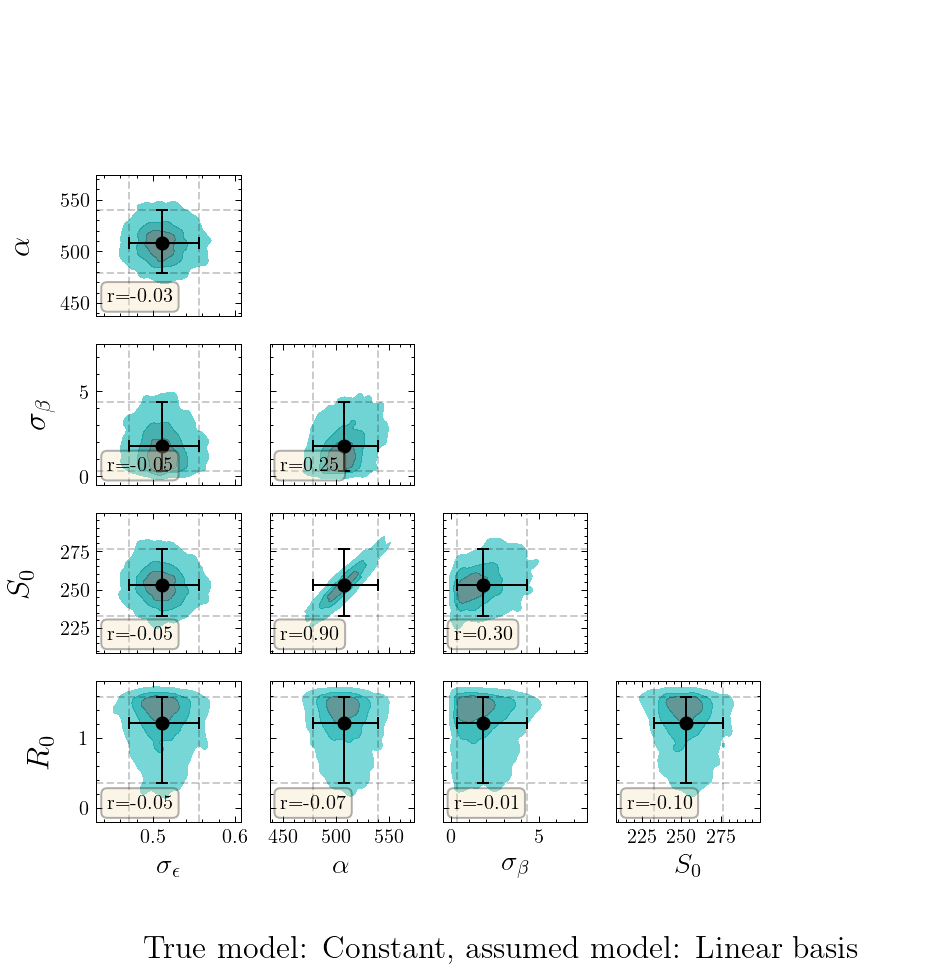

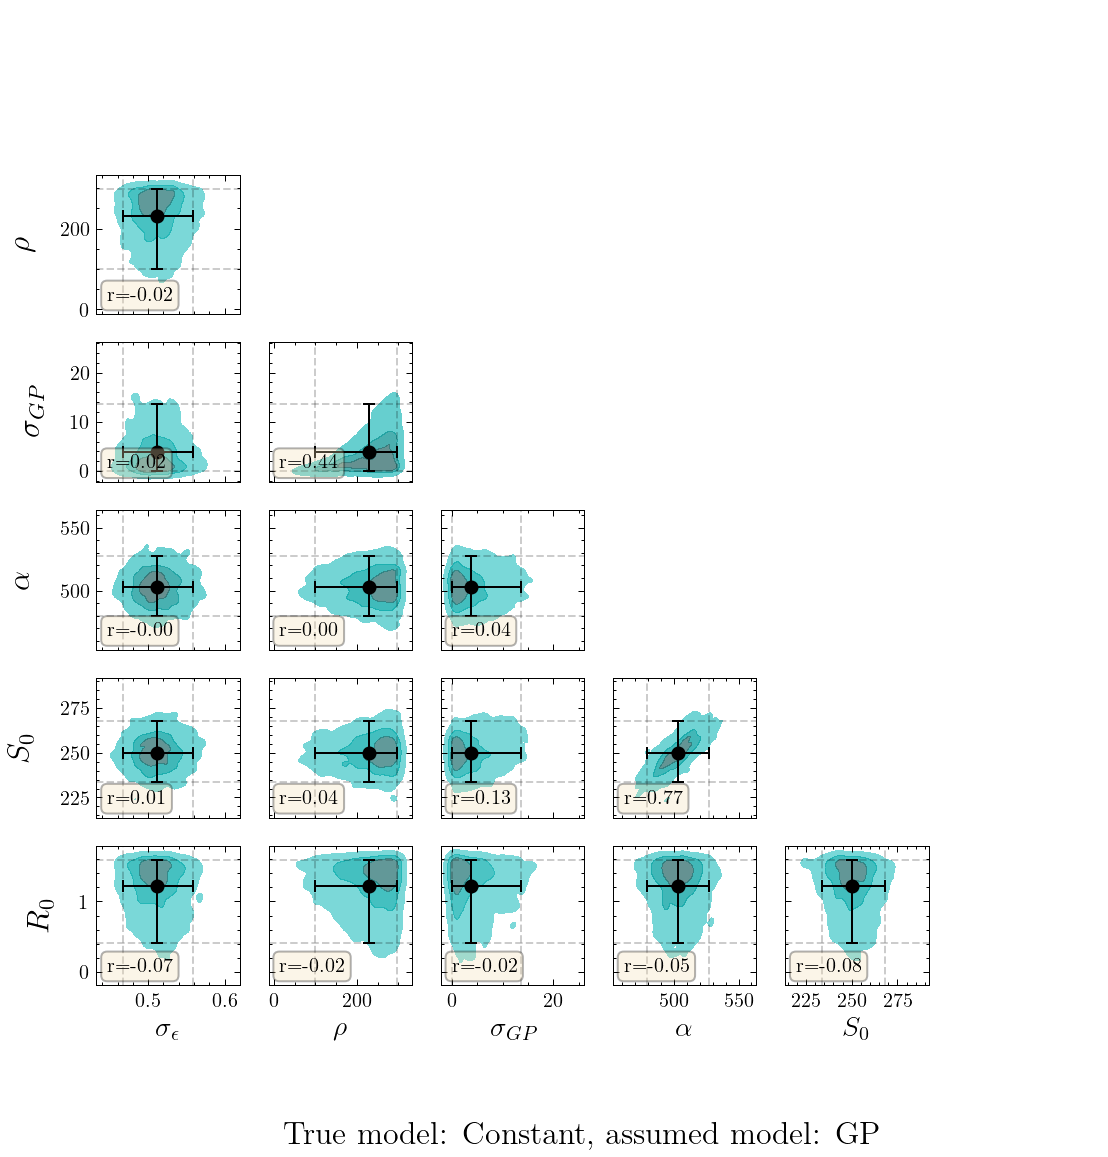

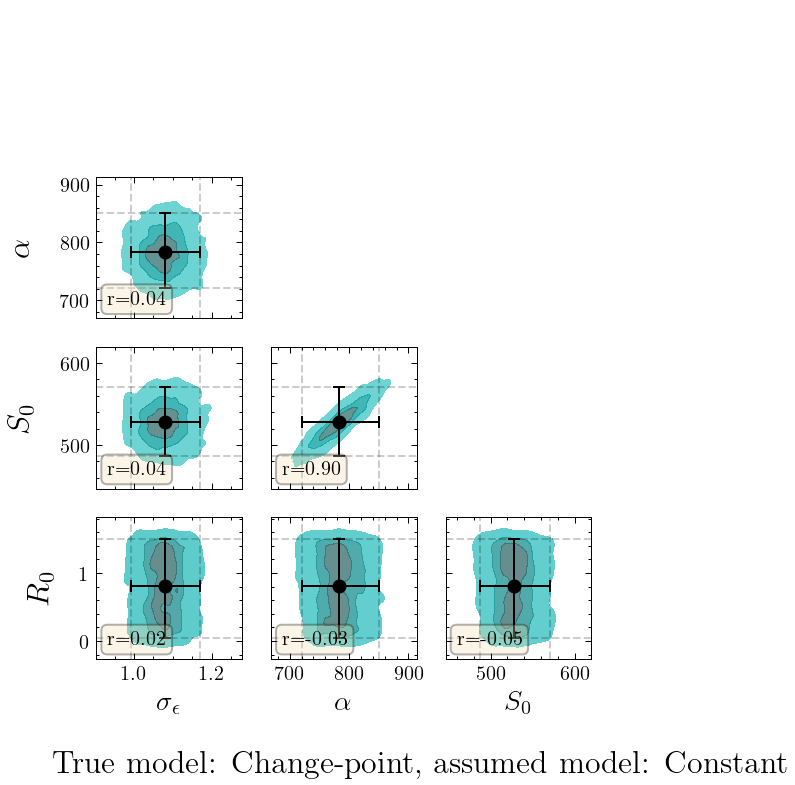

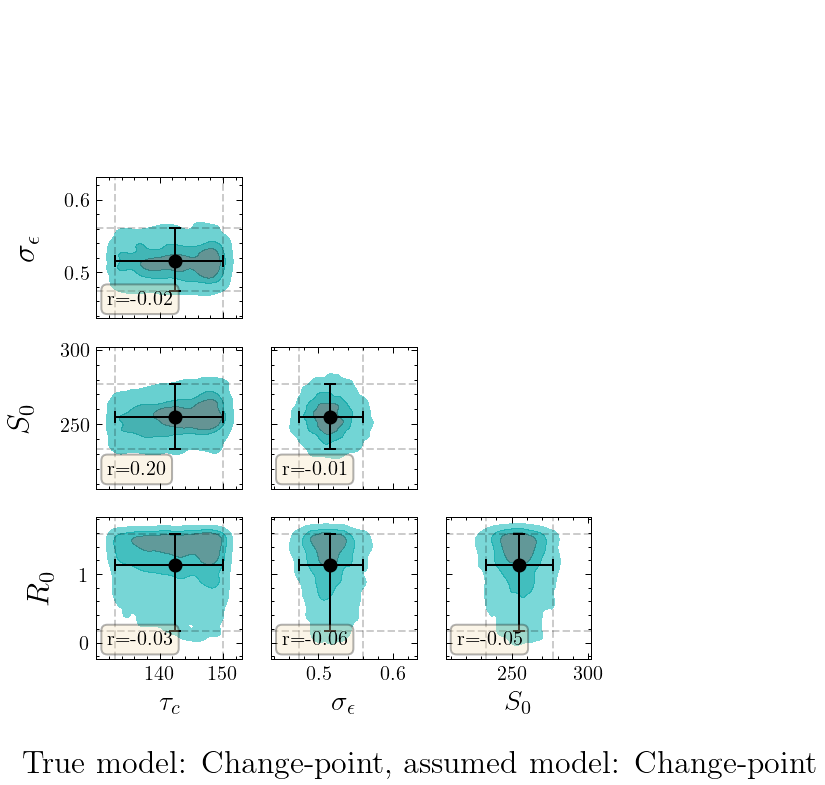

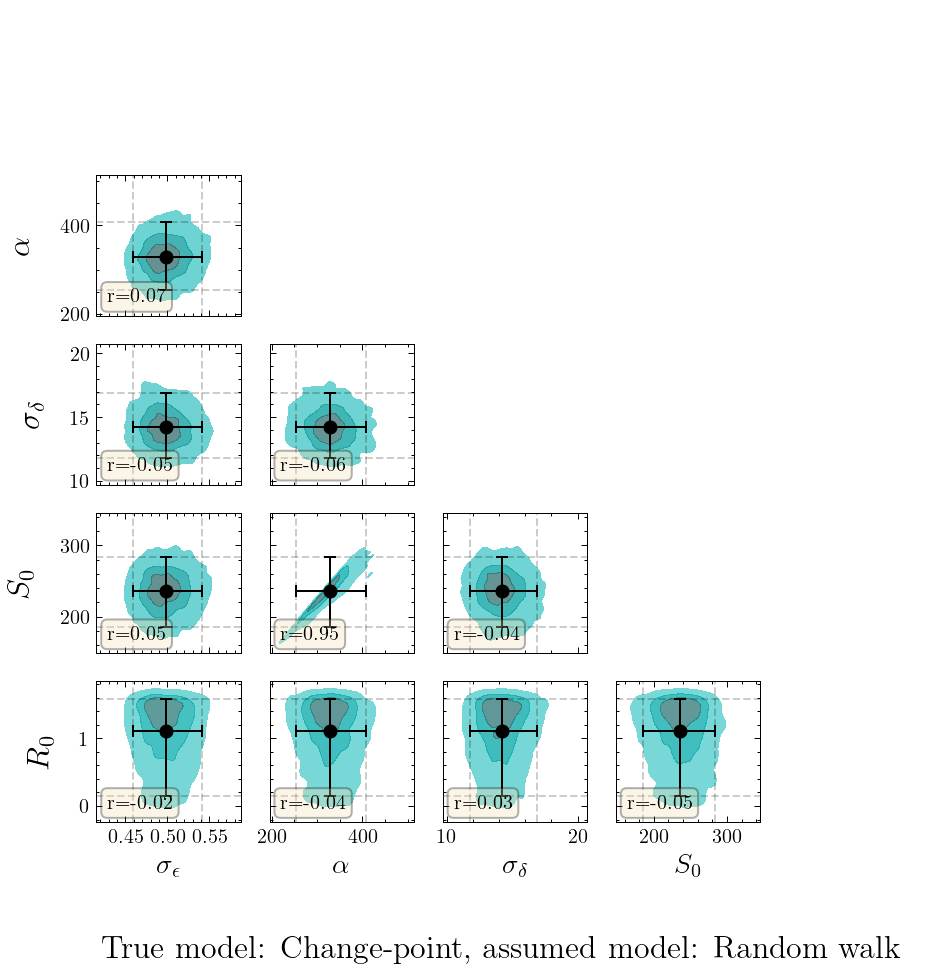

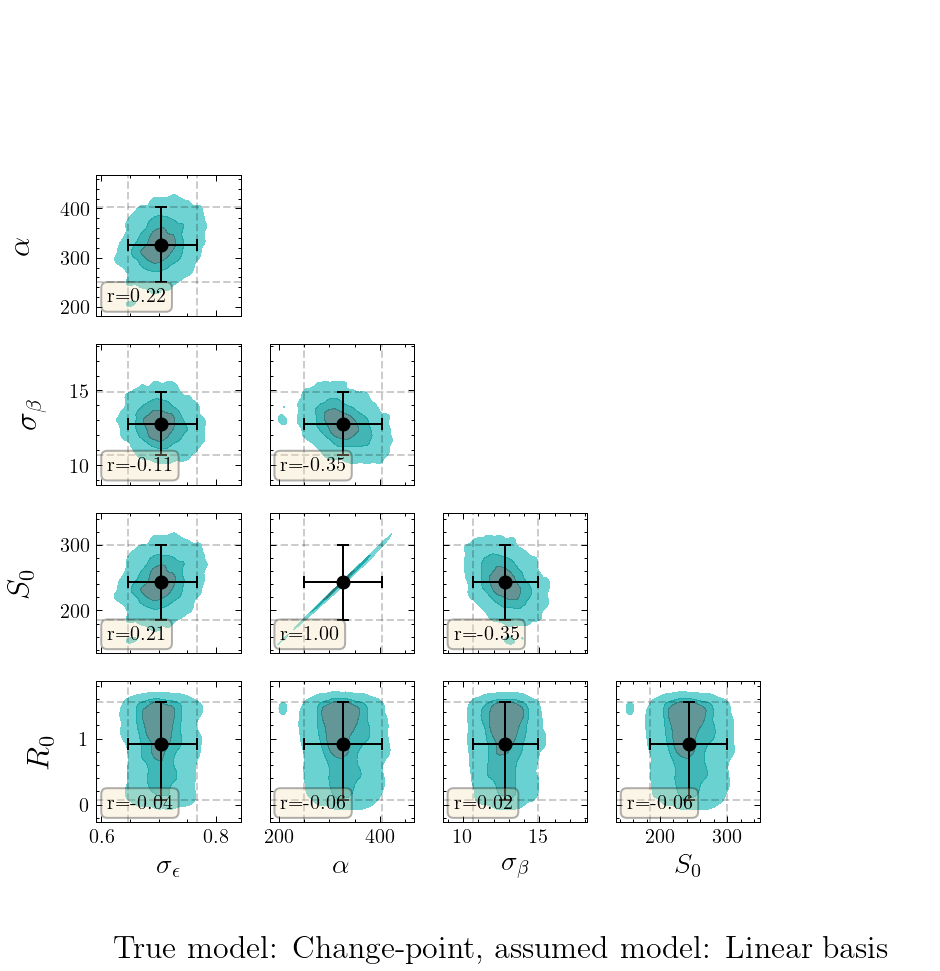

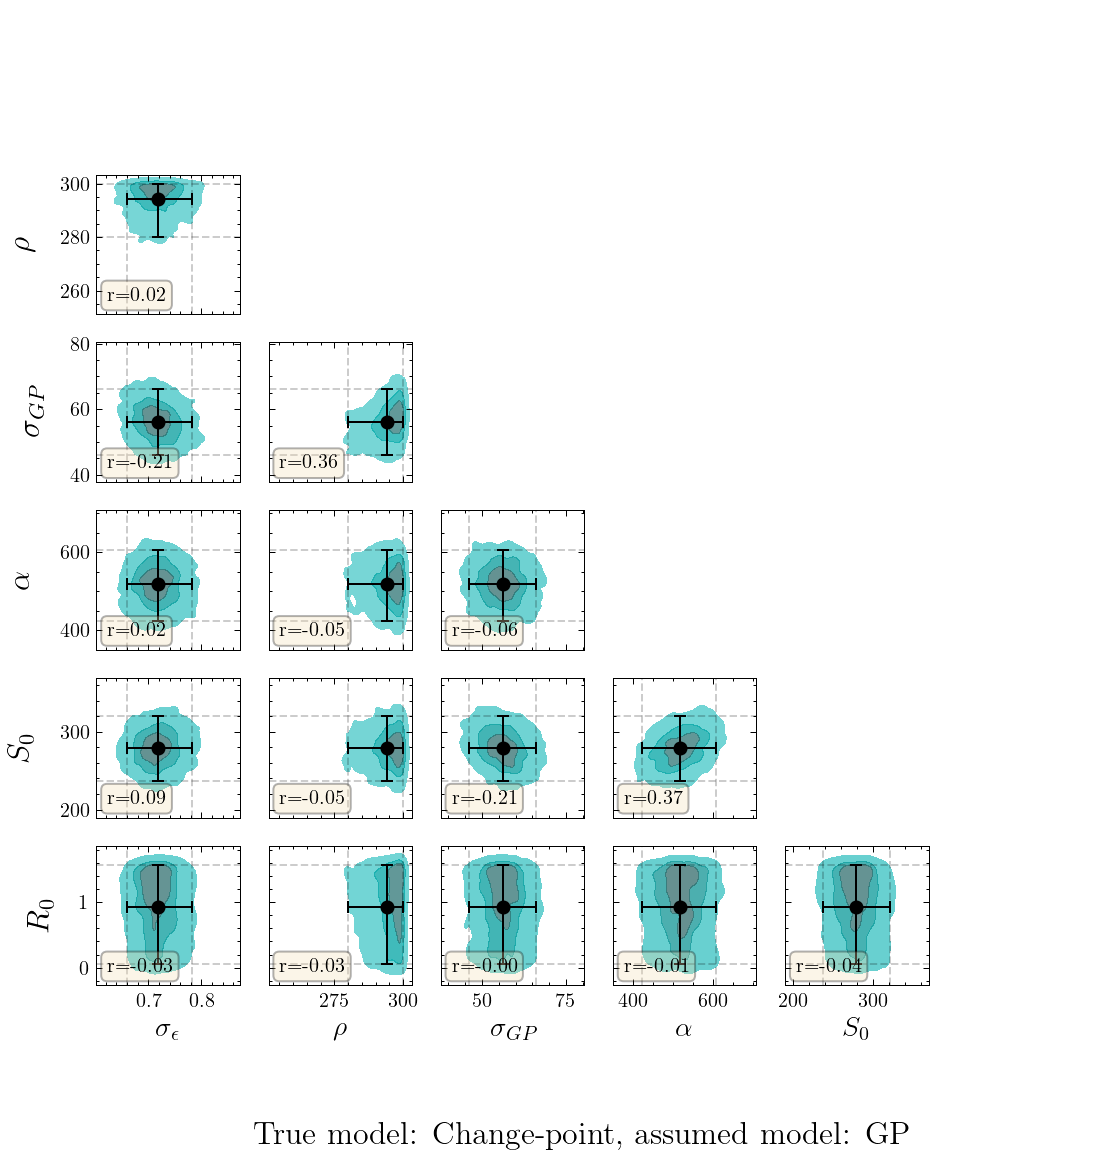

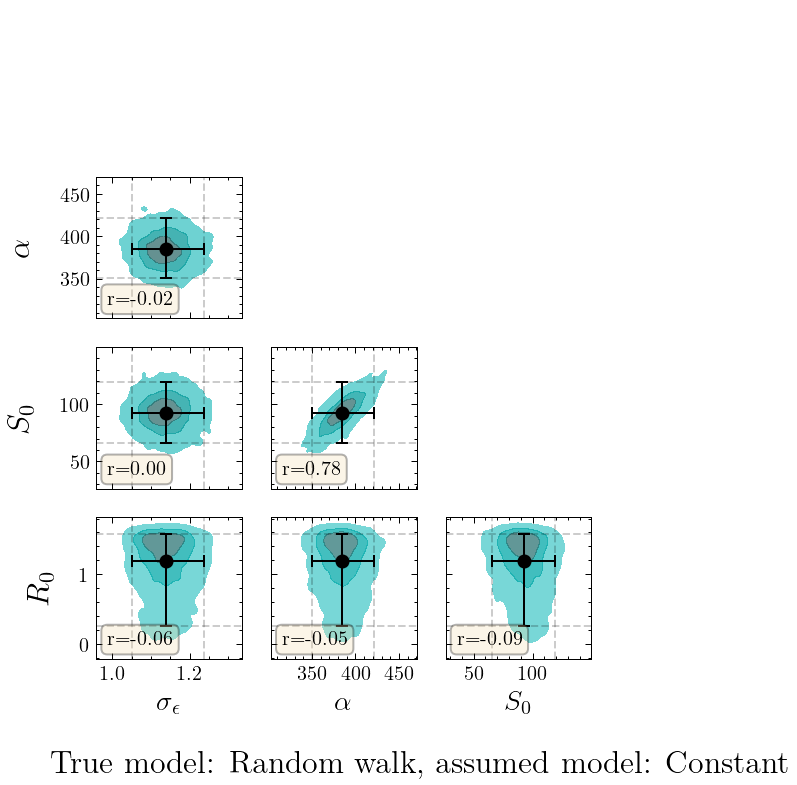

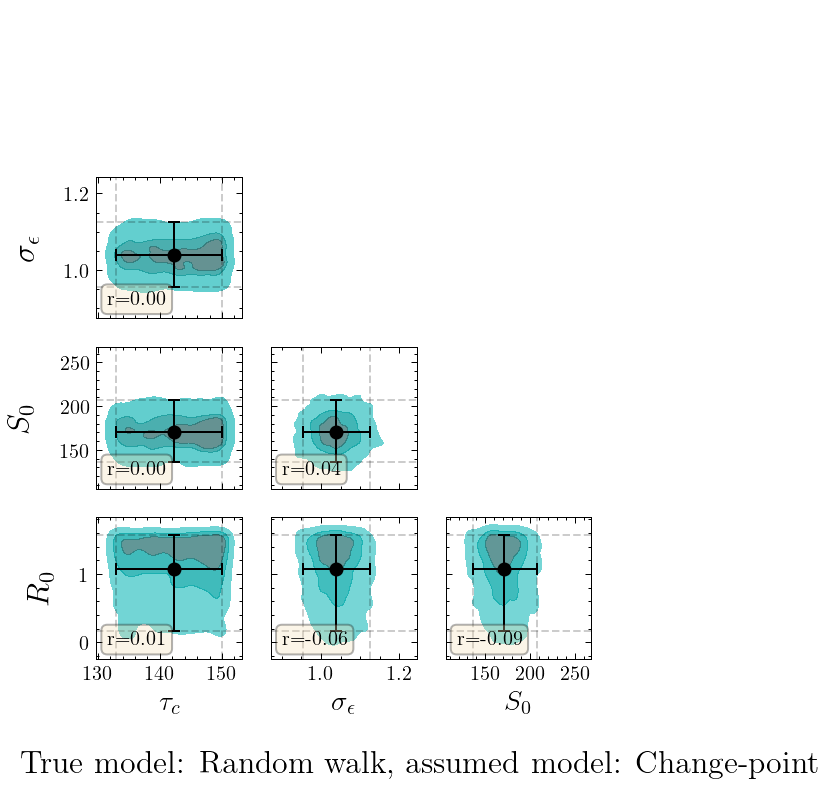

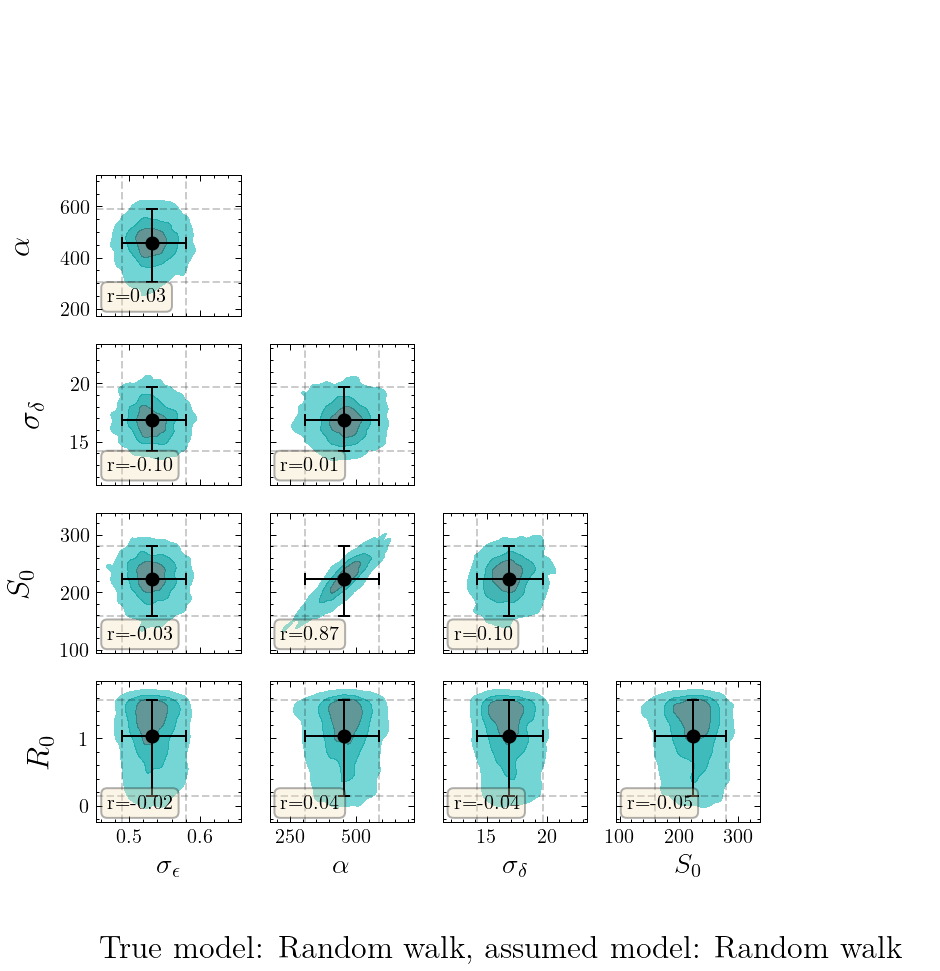

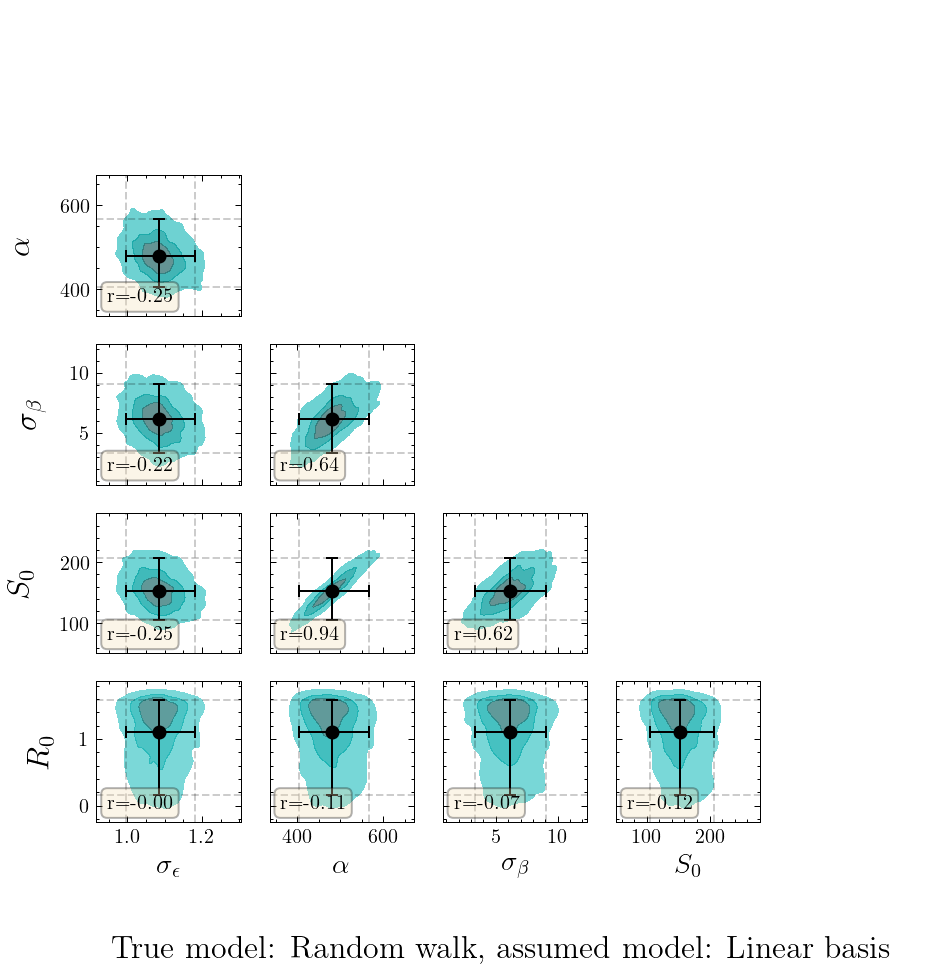

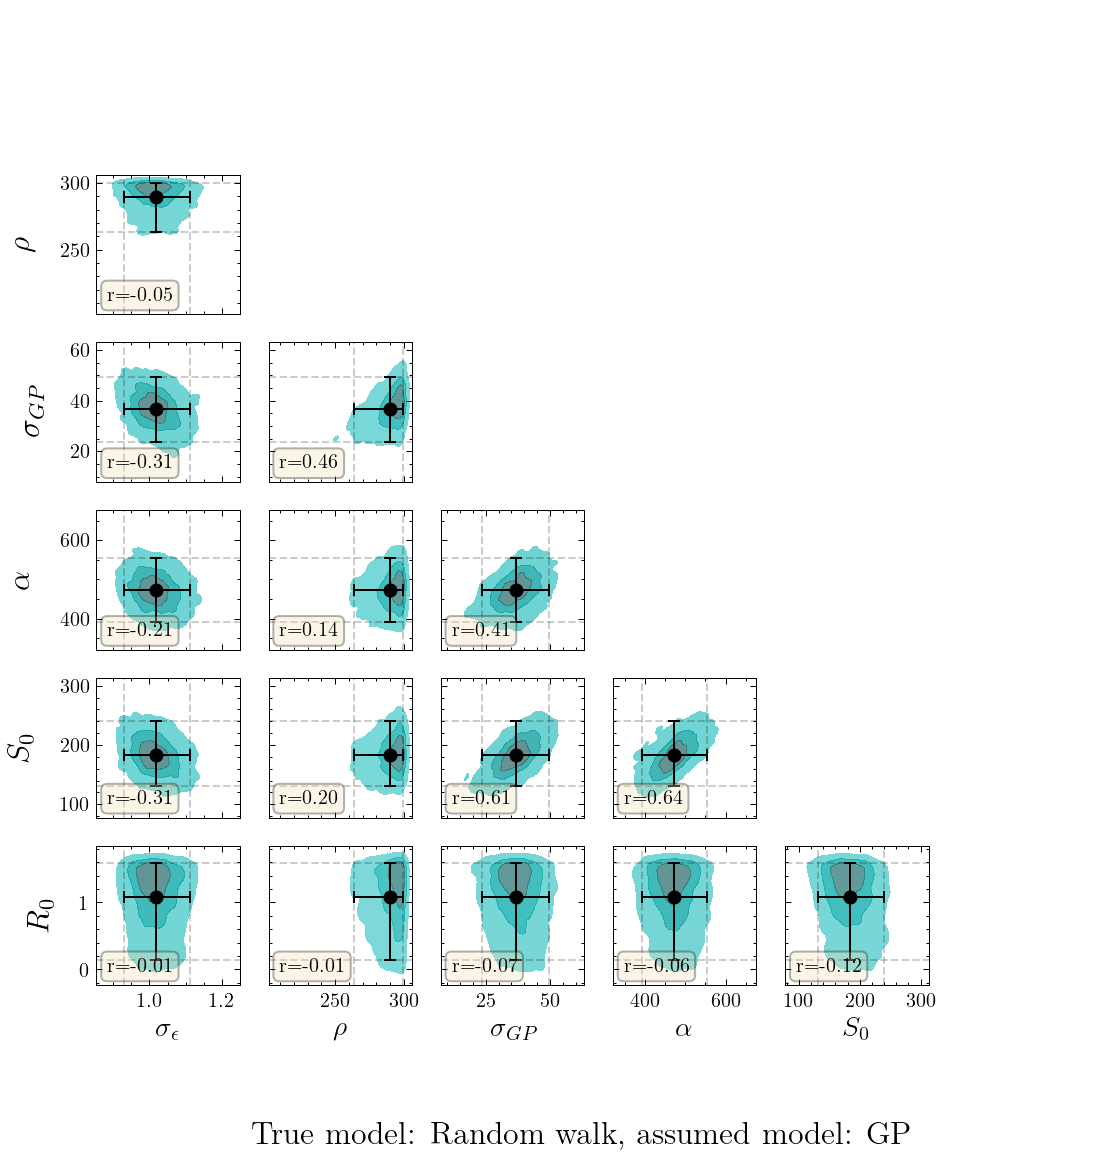

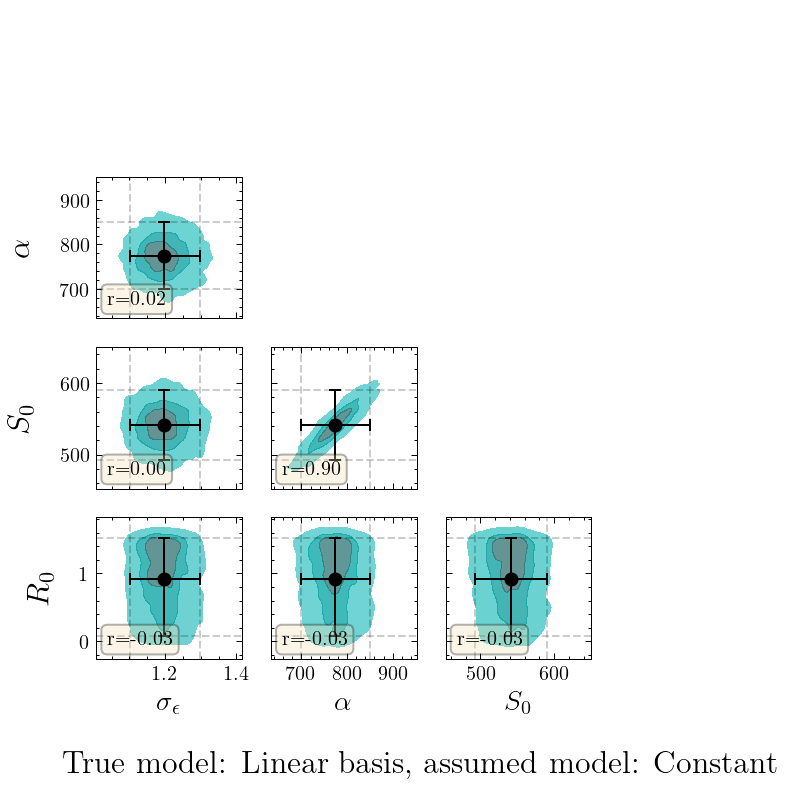

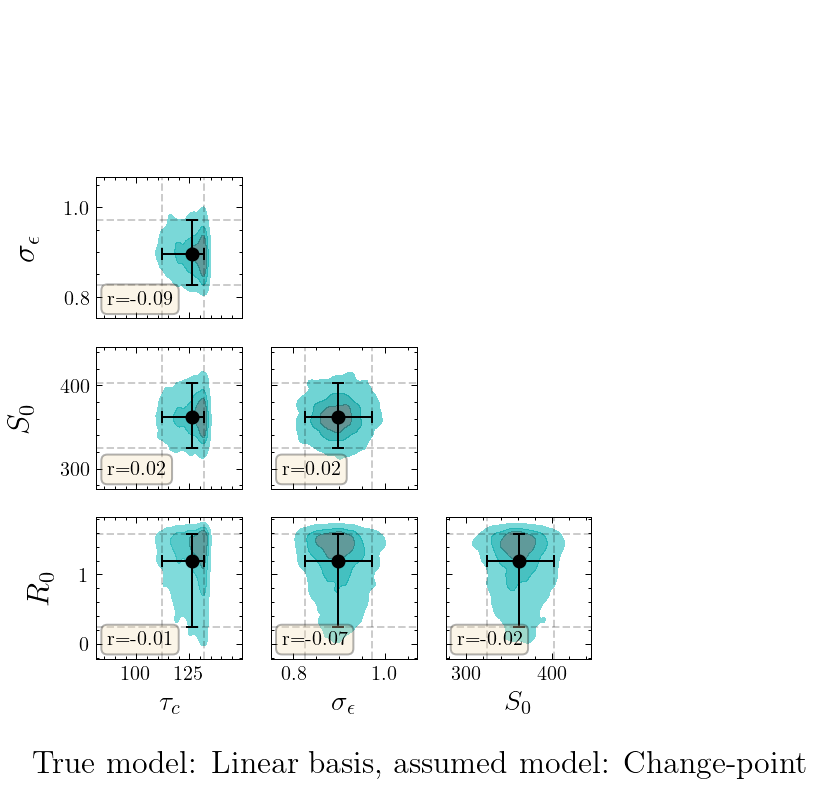

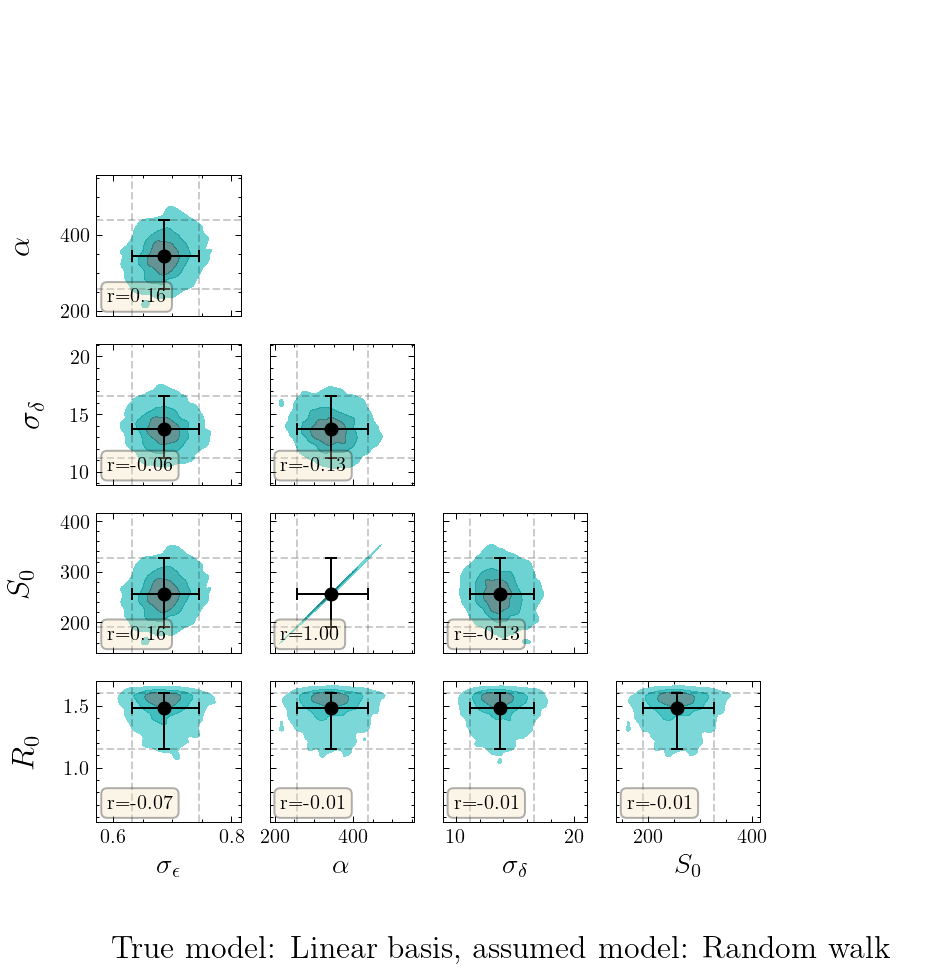

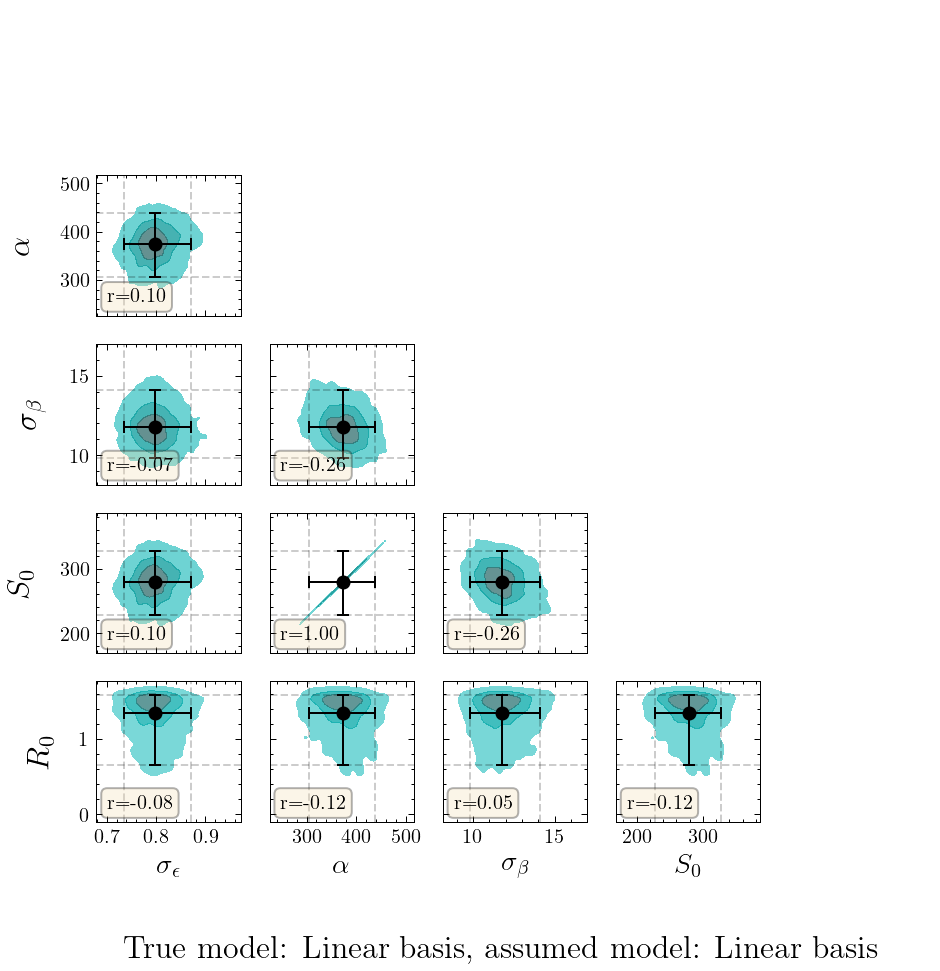

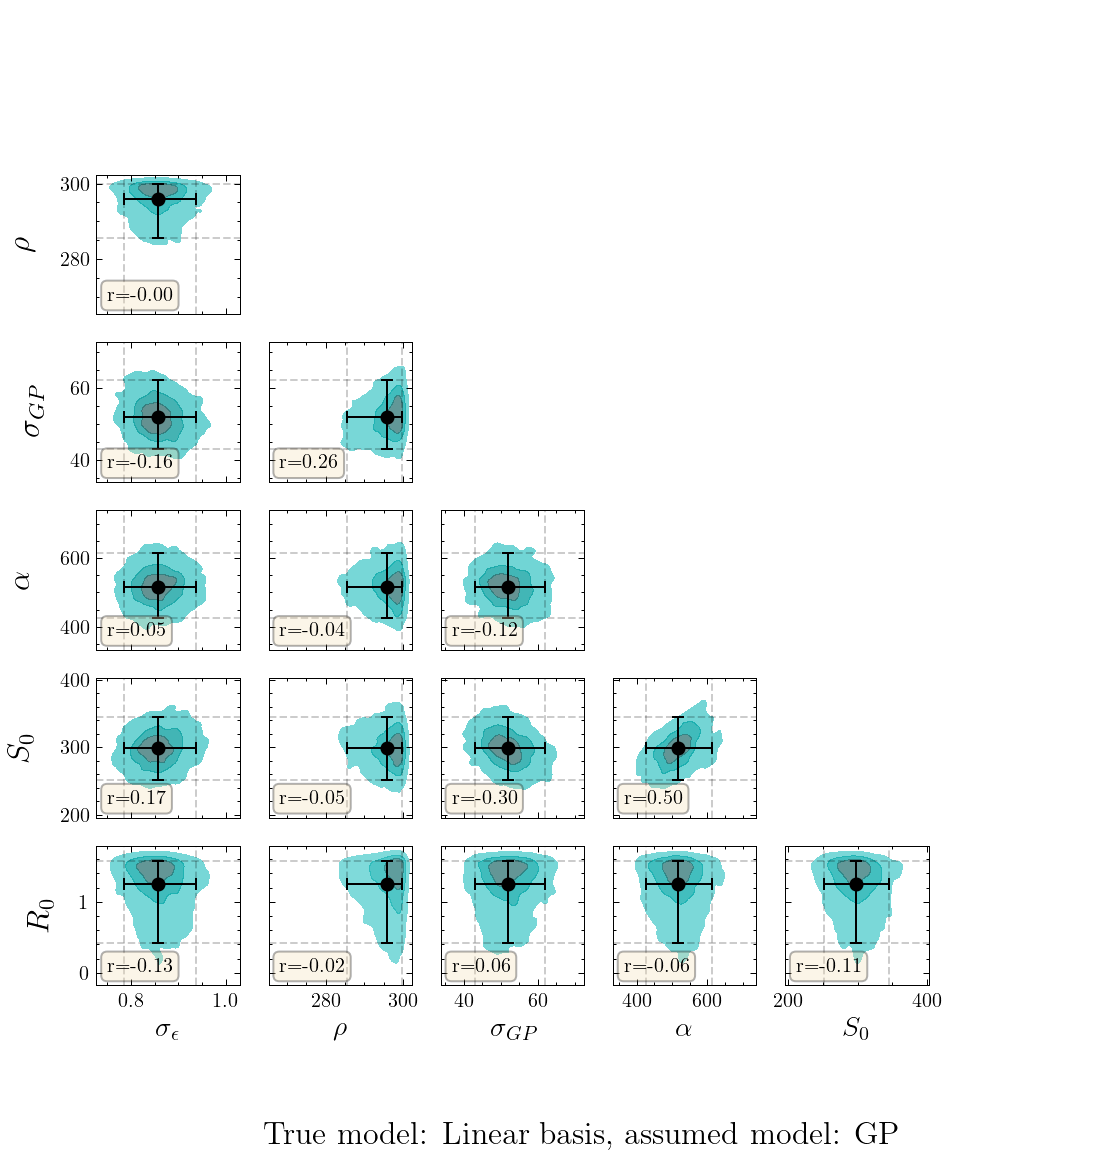

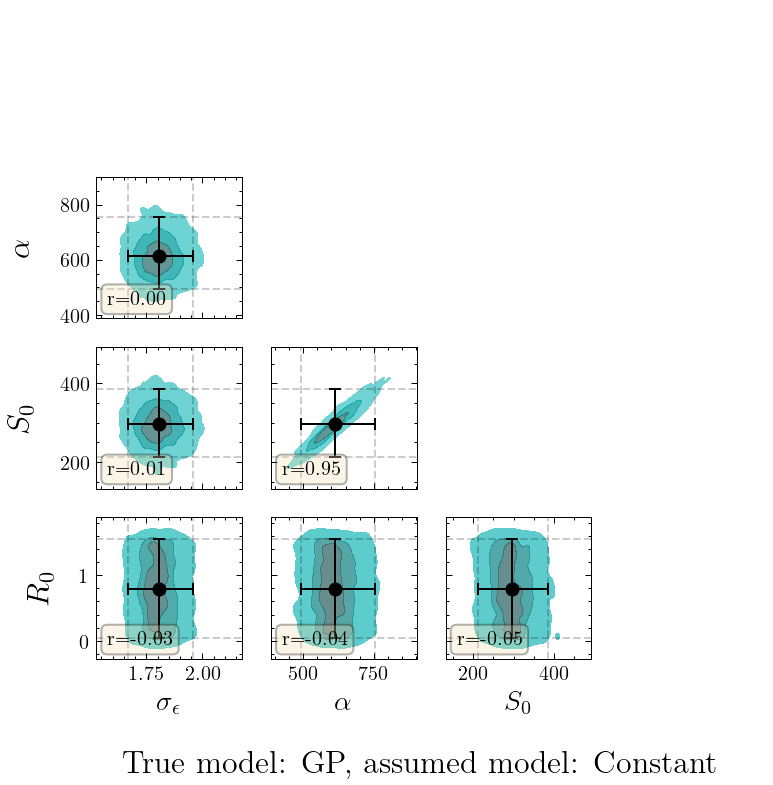

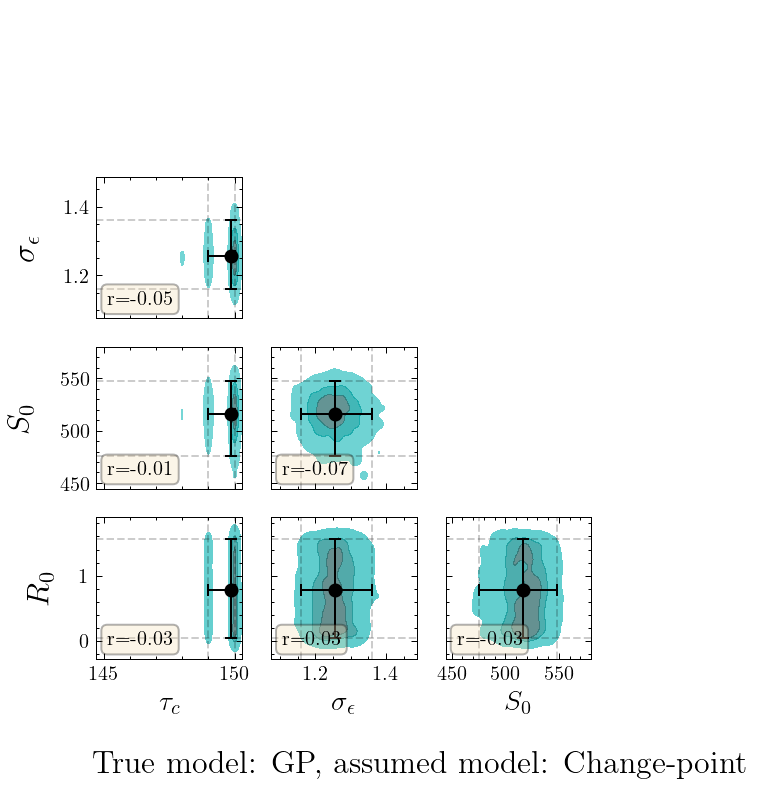

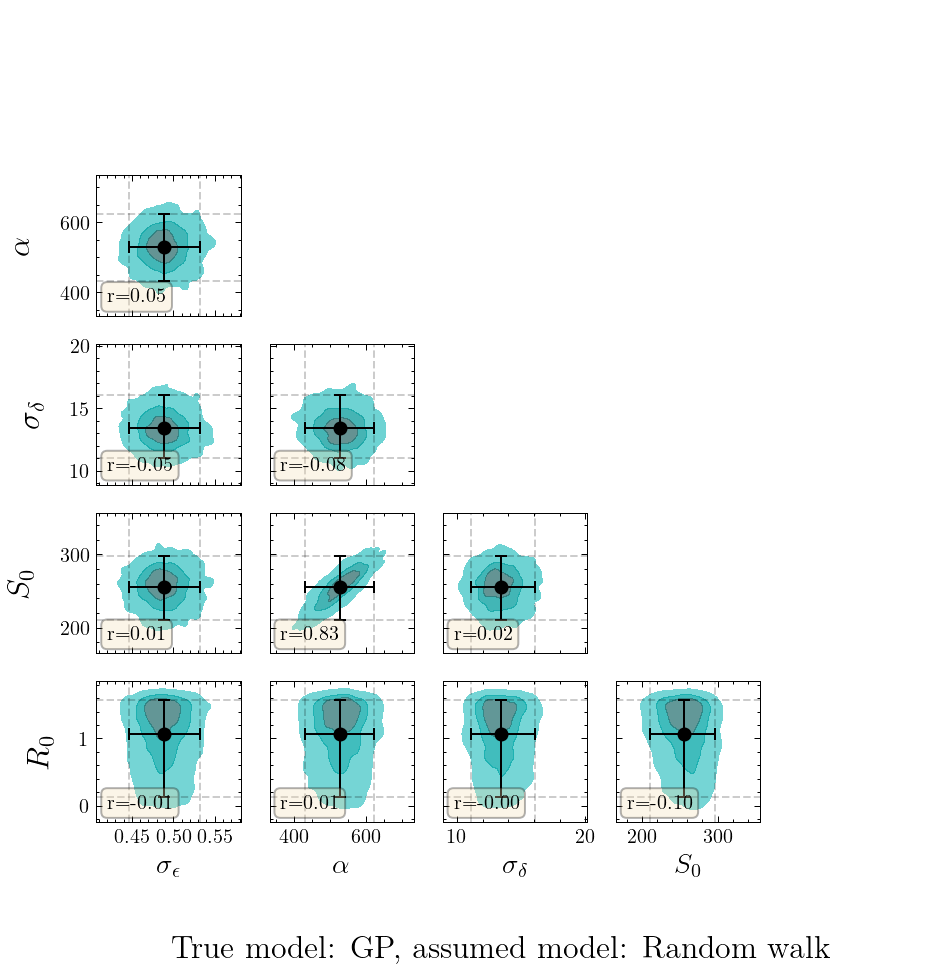

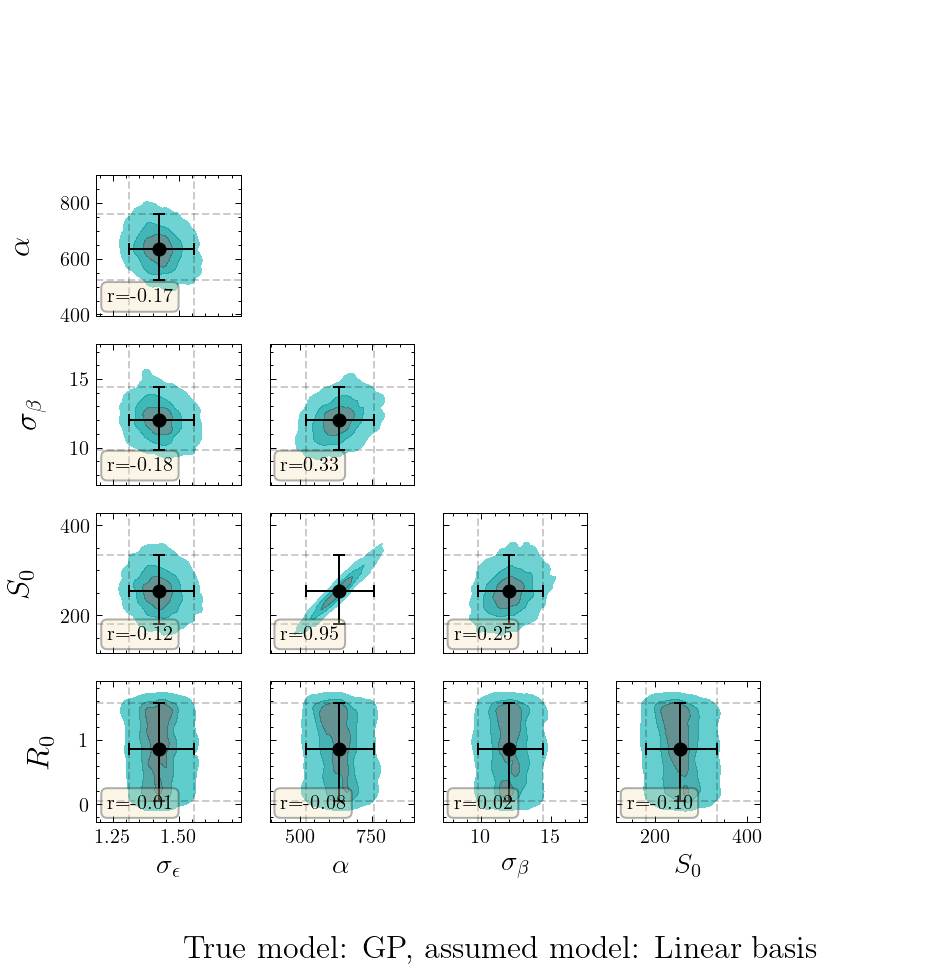

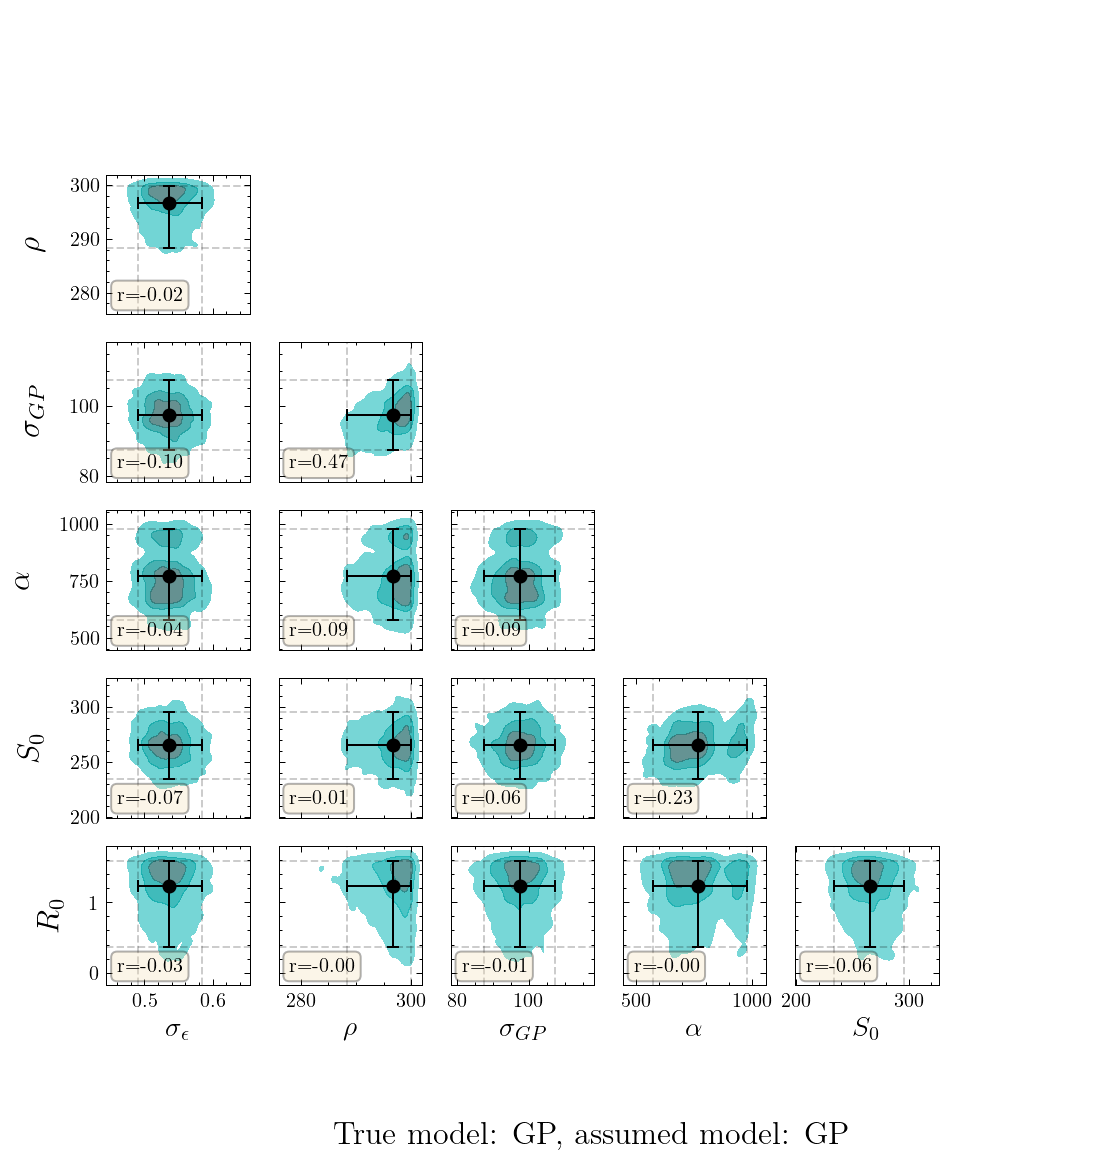

In [54]:
ctr = 0
bbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.45)

for key, trace in traces.items():
    figure_filepath = f'./figures/posterior_pairwise/{key[0]}_{key[1]}.png'
    if not os.path.exists(figure_filepath) or overwrite:
        true, assumed = key
        print(key)

        plotting_vars    = [x for x in trace.varnames if x in latex_names]    
        plotting_samples = {x:trace[x] for x in plotting_vars if x in trace.varnames} 
        
        for k,v in trace_extra_vars.items():
            plotting_samples[k] = v
            
        sample_df        = pd.DataFrame(plotting_samples)
        P = len(plotting_vars)
        fig_size_inches = P*1.5
        fig, axes = plt.subplots(P,P, figsize=(fig_size_inches,fig_size_inches),
                                 sharex='col', sharey='row')
        nticks=6

        var_lims = {x: (plotting_samples[x].min(), plotting_samples[x].max()) for x in plotting_vars}
        quantiles = [2.5, 97.5]
        for i in range(P):
            for j in range(P):

                if i != j and j>i:
                    plt.sca(axes[j,i])
                    x = plotting_samples[plotting_vars[i]]
                    y = plotting_samples[plotting_vars[j]]

                    corr = np.corrcoef(x,y)[1,0]
                    axes[j,i].text(0.075,0.1,f'r={corr:.2f}', fontsize=10,transform=axes[j,i].transAxes,
                                  fontweight='bold', bbox=bbox_props)

                    sns.kdeplot(x,y=y, **kde_kwargs, ax=axes[j,i], alpha=0.75)
                    ylow, yhi = var_lims[plotting_vars[j]]
                    yticks = np.linspace(ylow, yhi, nticks)

                    xlow, xhi = var_lims[plotting_vars[i]]
                    xticks = np.linspace(xlow, xhi, nticks)
                    xmean, ymean = x.mean(), y.mean()

                    plt.scatter(xmean,ymean, color='k')
                    x_qs = np.percentile(x, quantiles)
                    plt.plot(x_qs,[ymean,ymean], color='k', marker='|')

                    y_qs = np.percentile(y, quantiles)
                    plt.plot([xmean,xmean], y_qs, color='k', marker='_')

                    [plt.axvline(x, color='k', linestyle='--', alpha=0.2) for x in x_qs]
                    [plt.axhline(y, color='k', linestyle='--', alpha=0.2) for y in y_qs]

                    if i == 0:
                        plt.ylabel(latex_names[plotting_vars[j]], fontsize=16,labelpad=12)
                else:
                    axes[j,i].axis('off')

        for j in range(P):            
            axes[-1,j].set_xlabel(latex_names[plotting_vars[j]], fontsize=14,labelpad=3)

        plt.suptitle(f'True model: {true}, assumed model: {assumed}',y=0.02, fontsize=16)
        plt.savefig(figure_filepath, dpi=400, bbox_inches='tight')

## Second try at pairwise posterior plots

#### Determine number of subplots per figure

In [142]:
vars_per_assumed = {}
for key, trace in traces.items():
    _, assumed = key

    plotting_vars    = [x for x in trace.varnames if x in latex_names]    

    for k,v in trace_extra_vars.items():
        plotting_samples[k] = v

    vars_per_assumed[assumed] = len(plotting_vars)

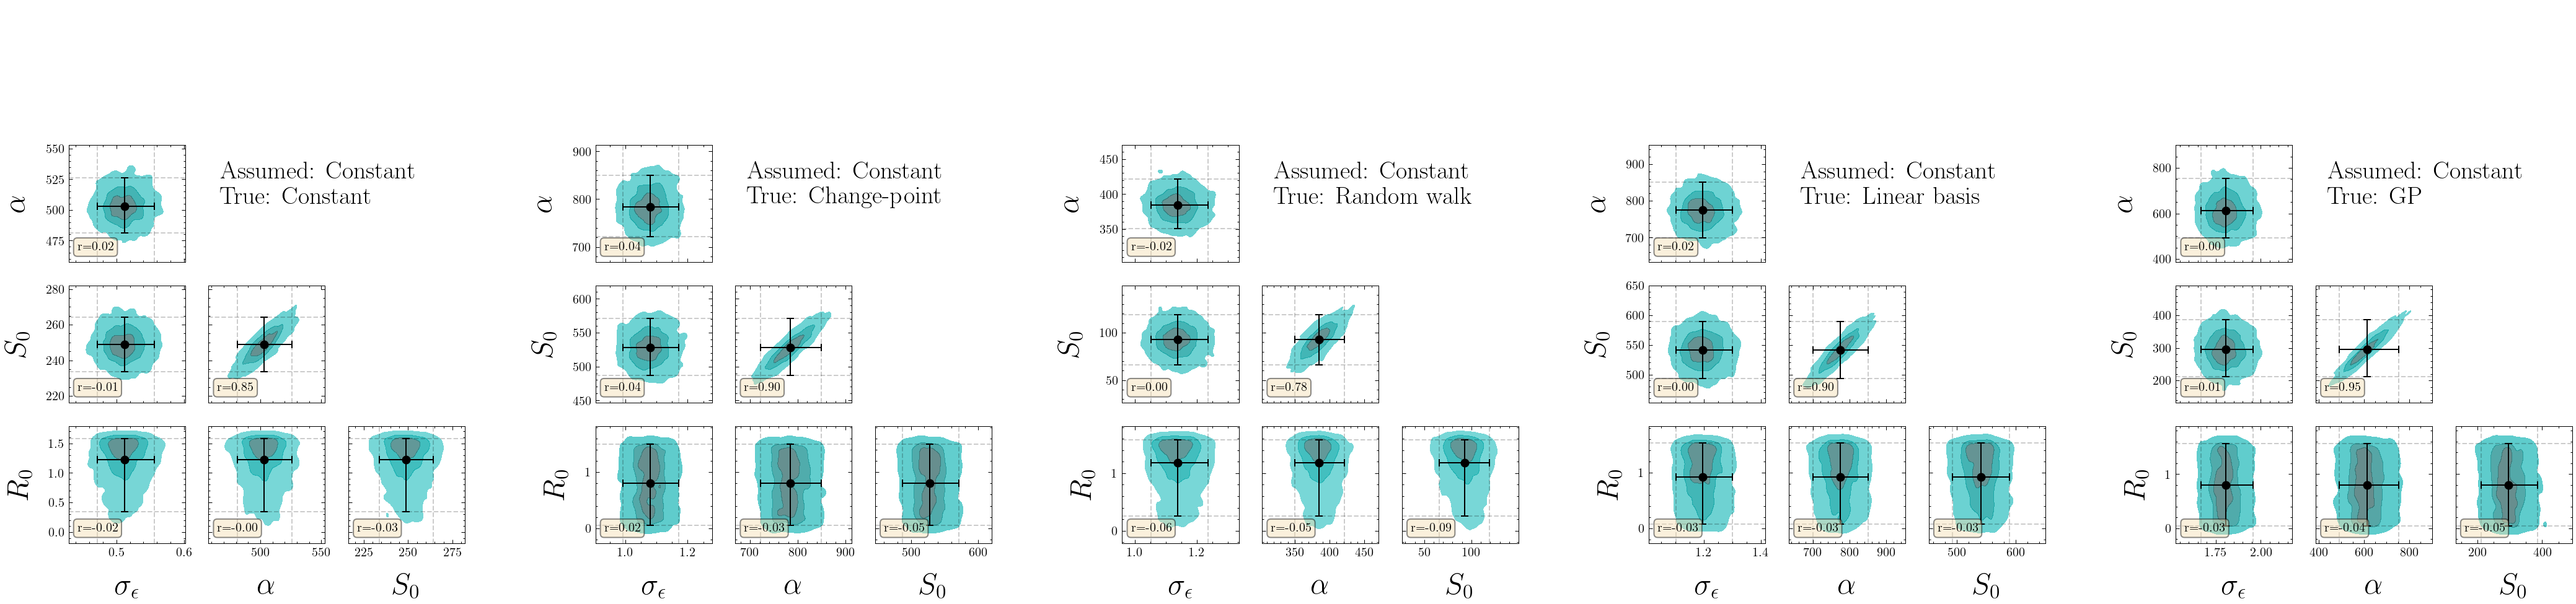

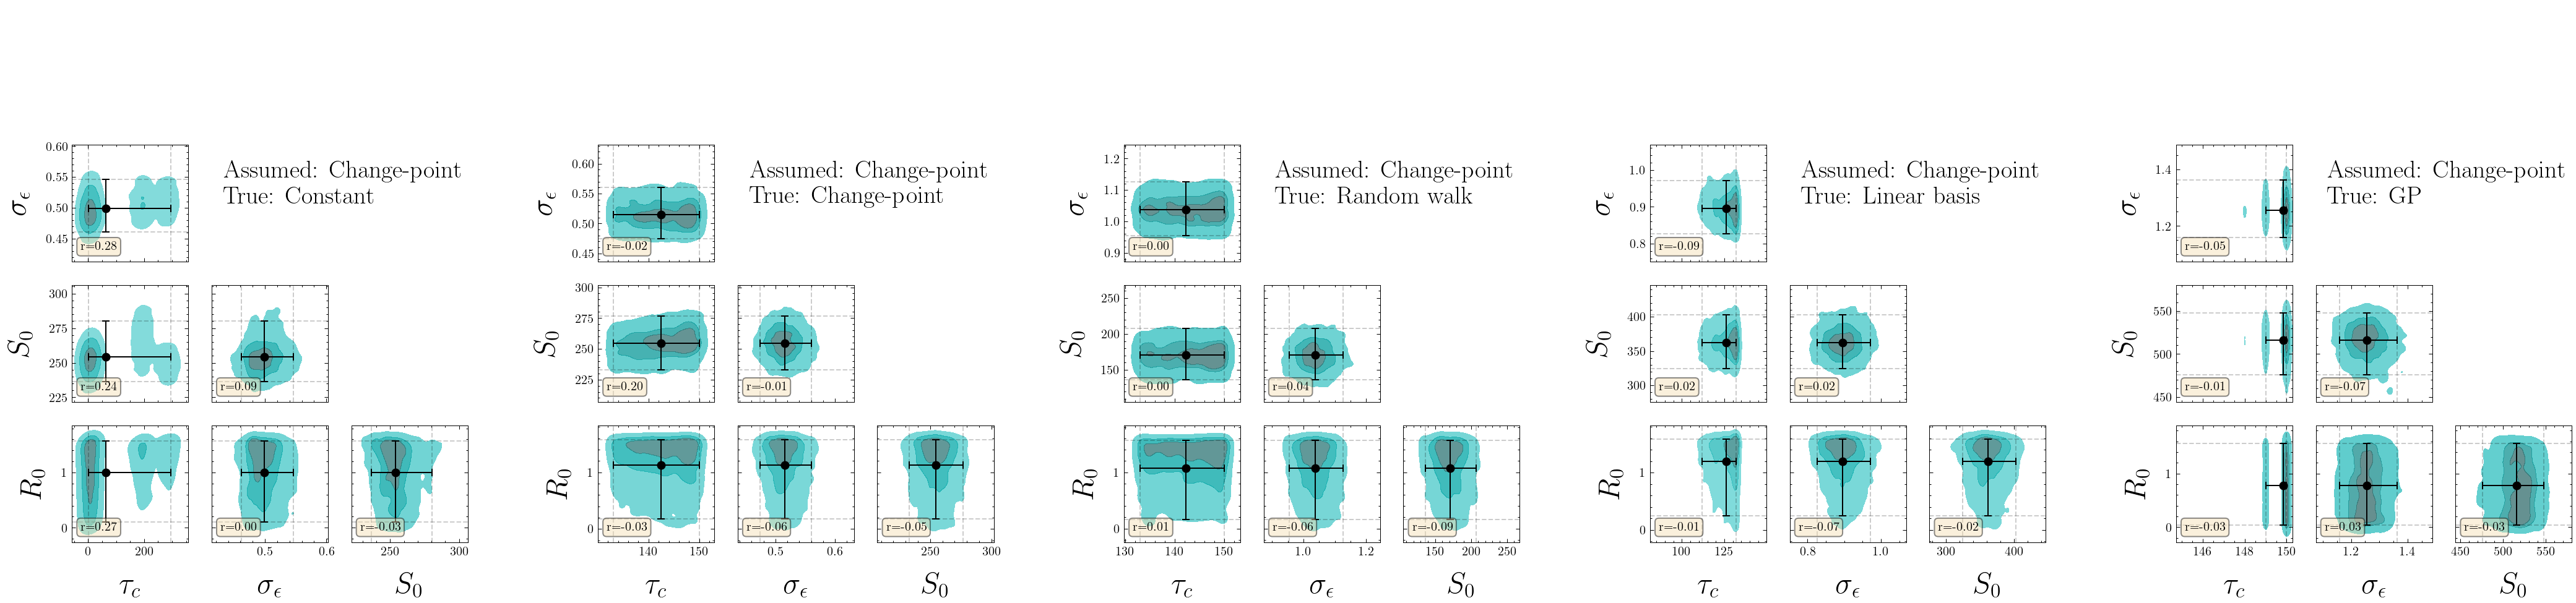

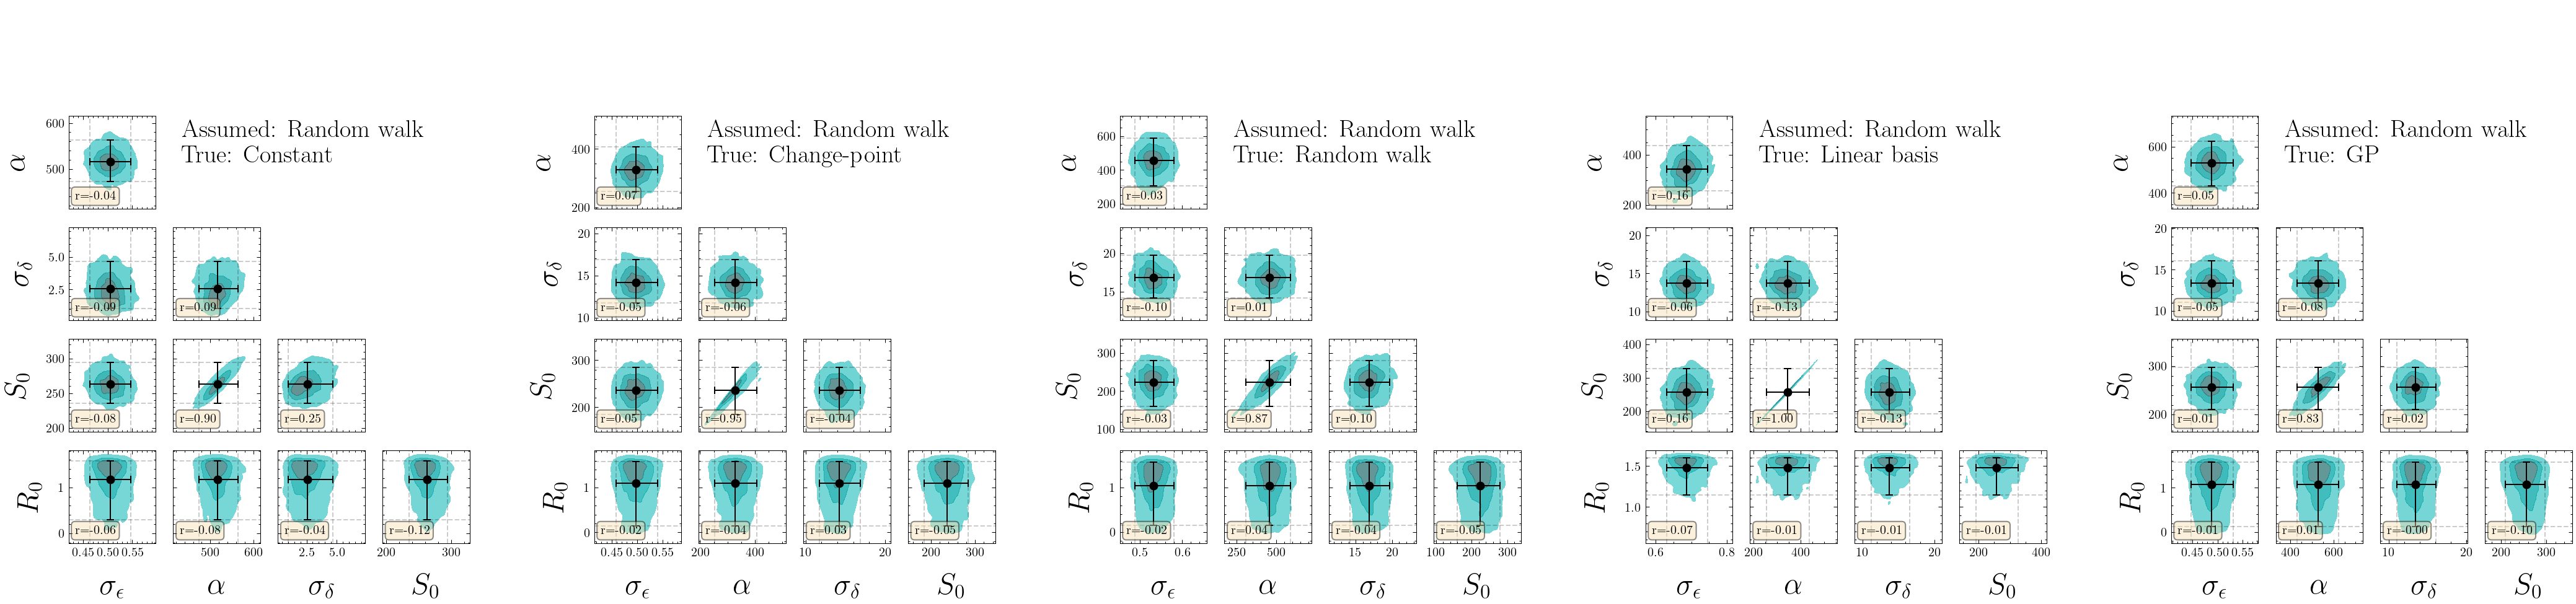

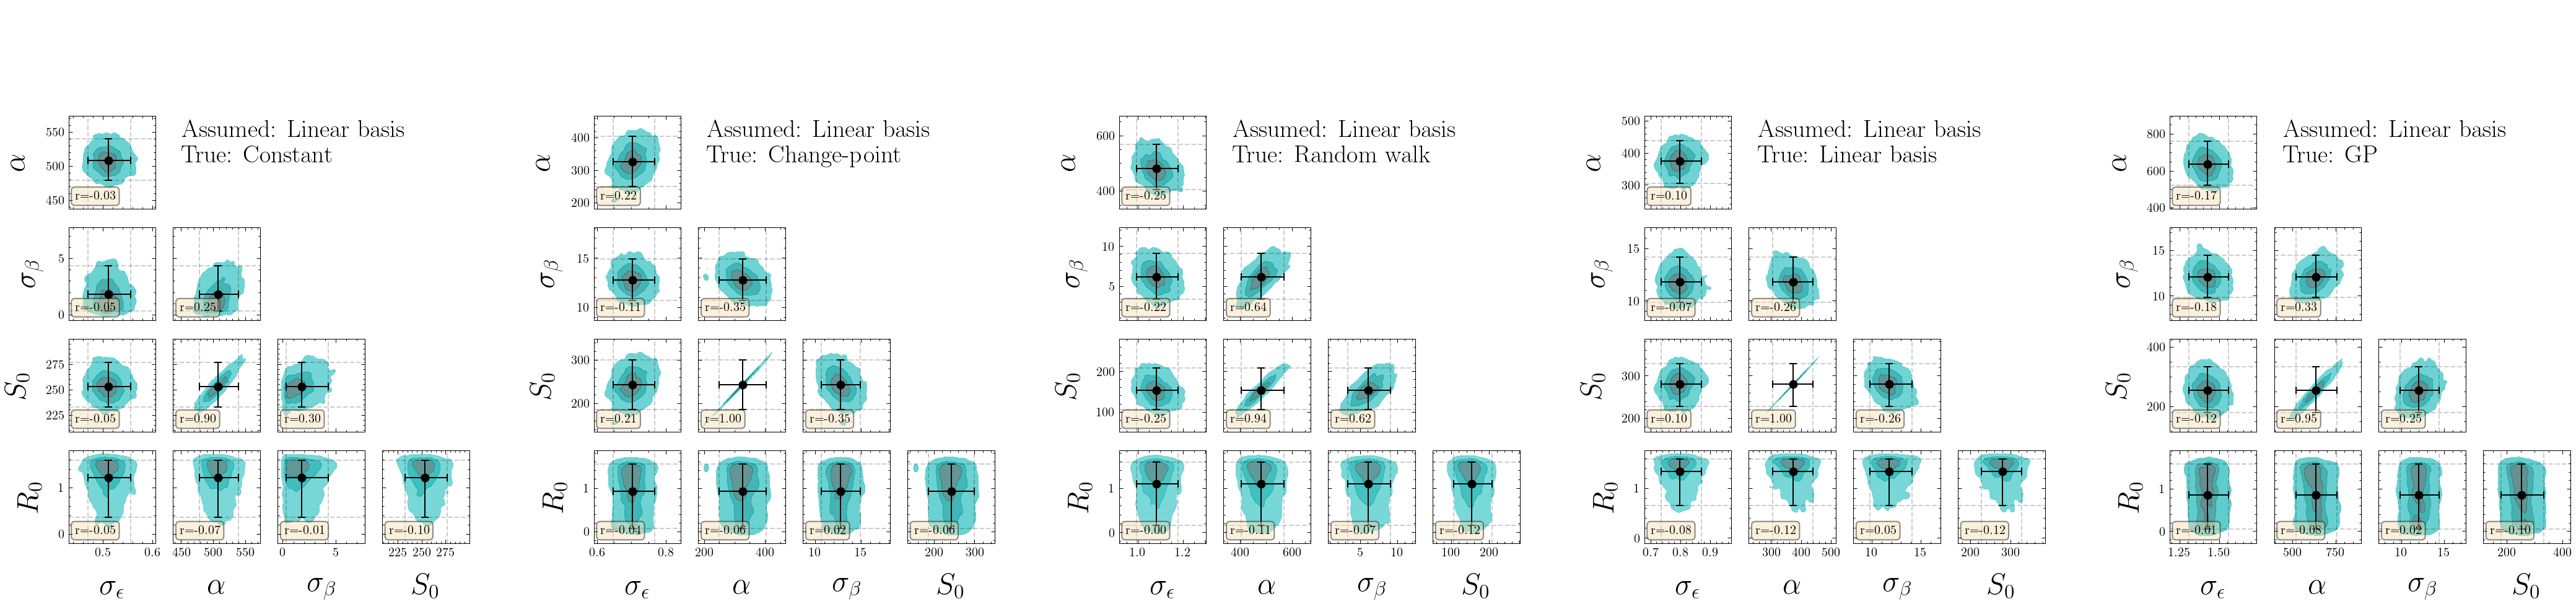

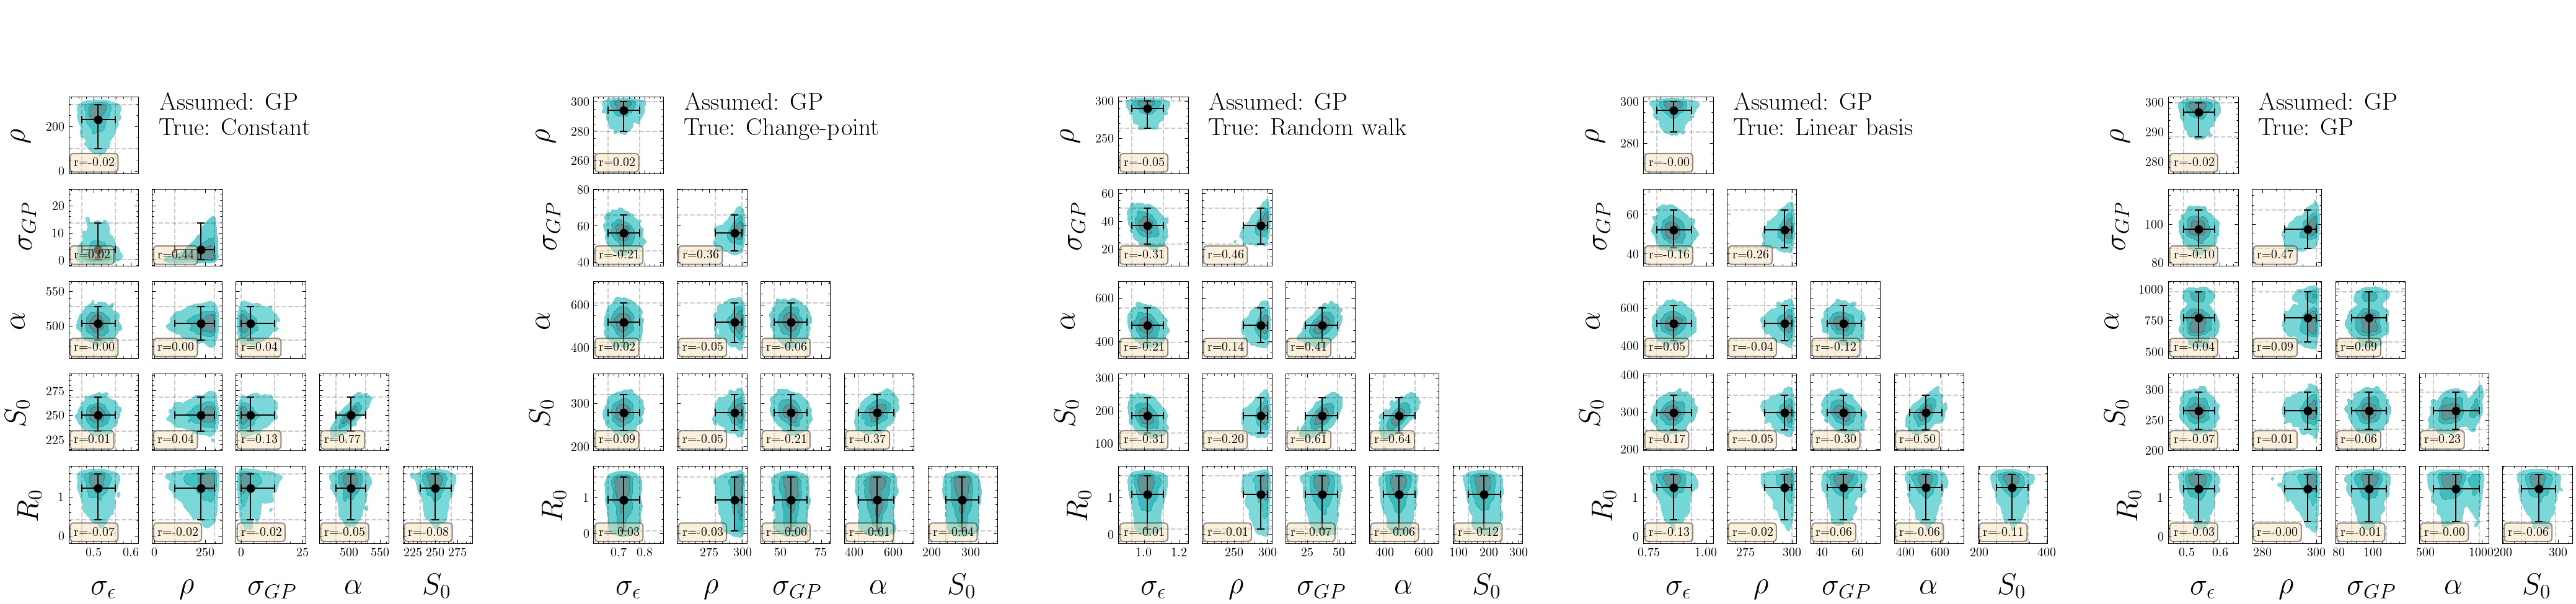

In [211]:
names            =  ['Constant', 'Change-point', 'Random walk', 'Linear basis', 'GP']


label_fontsize = 24
bbox_props     = dict(boxstyle='round', facecolor='wheat', alpha=0.45)
for m, assumed in enumerate(names):
    
    fig, axes = plt.subplots(vars_per_assumed[assumed],
                         5*(vars_per_assumed[assumed]-1), figsize=(30,8), sharex='col')
    
    for n, true in enumerate(names):
        trace = traces[(true, assumed)]
        
        plotting_vars    = [x for x in trace.varnames if x in latex_names]    
        plotting_samples = {x:trace[x] for x in plotting_vars if x in trace.varnames} 
        P = len(plotting_vars)

        for k,v in trace_extra_vars.items():
            plotting_samples[k] = v
            
        sample_df        = pd.DataFrame(plotting_samples)
                                                                      
        for i in range(P-1):
            for j in range(P):
                plt.sca(axes[j,i+n*(P-1)])
                if i != j and j>i:
                    x = plotting_samples[plotting_vars[i]]
                    y = plotting_samples[plotting_vars[j]]


                    corr = np.corrcoef(x,y)[1,0]
                    plt.text(0.075,0.1,f'r={corr:.2f}', fontsize=10,transform=plt.gca().transAxes,
                                  fontweight='bold', bbox=bbox_props)

                    sns.kdeplot(x,y=y, **kde_kwargs, ax=plt.gca(), alpha=0.75)
                    '''ylow, yhi = var_lims[plotting_vars[j]]
                    yticks = np.linspace(ylow, yhi, nticks)

                    xlow, xhi = var_lims[plotting_vars[i]]
                    xticks = np.linspace(xlow, xhi, nticks)'''
                    xmean, ymean = x.mean(), y.mean()

                    plt.scatter(xmean,ymean, color='k')
                    x_qs = np.percentile(x, quantiles)
                    plt.plot(x_qs,[ymean,ymean], color='k', marker='|')

                    y_qs = np.percentile(y, quantiles)
                    plt.plot([xmean,xmean], y_qs, color='k', marker='_')

                    [plt.axvline(x, color='k', linestyle='--', alpha=0.2) for x in x_qs]
                    [plt.axhline(y, color='k', linestyle='--', alpha=0.2) for y in y_qs]

                    if i % (P-1) == 0:
                        plt.ylabel(latex_names[plotting_vars[j]], fontsize=label_fontsize,labelpad=12)
                        plt.gca().yaxis.set_tick_params(labelleft=True)
                    else:
                        plt.gca().yaxis.set_tick_params(labelleft=False)

                        
                    if j==(P-1):
                        plt.xlabel(latex_names[plotting_vars[i]], fontsize=label_fontsize,labelpad=12)
                else:
                    plt.axis('off')
                    
                bbox=plt.gca().get_position()
                offset=0.04
                plt.gca().set_position([bbox.x0+n*offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                    
                if j == 1 and i == 1:
                    axes[j,i+n*(P-1)].text(0.1, 0.5, f'Assumed: {assumed}\n\tTrue: {true}', fontsize=20, transform=axes[j,i+n*(P-1)].transAxes)
    
    figure_filepath = f'./figures/posterior_pairwise/{assumed}.png'                
    plt.savefig(figure_filepath, dpi=400, bbox_inches='tight')